In [1]:
# Importing the required libraries
from IPython.display import display
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import time
import easydict

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset

from vae_lstm_model import VAE_LSTM

# Training device check-up
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

writer = SummaryWriter()

# Defining DOE custom mape formula
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / max(y_true))) * 100

Using device cuda:0


#### FETCHING AND PROCESSING CALENDER FEATURES

In [2]:
# Specifying the path of file
path= r"C:\Users\sashah8\OneDrive - North Carolina State University\Desktop\DOE\DOE_Q1\L3\data_cleaned"

In [3]:
# Just for previewing the column name
date = pd.read_csv(os.path.join(path, "Date.csv"))
print("Sample dataframe: ")
display(date.head(2))
print("Available unique categories: ")
display(date.nunique())

Sample dataframe: 


,Month,Day,Weekday,Hour
0,1,1,1,0
1,1,1,1,1


Available unique categories: 


Month      12
Day        31
Weekday     2
Hour       24
dtype: int64

In [4]:
# One-hot encoding the categorical calendar features
date_enc = OneHotEncoder(sparse_output=False)
categorical_data = date_enc.fit_transform(date)
categorical_data

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [5]:
category_count = [len(x_len) for x_len in date_enc.categories_]
category_count

[12, 31, 2, 24]

#### PROCESSING CONTINUOUS FEATURES FOR ALL AVAILABLE ZONES

PROCESSING LOAD DATA

In [6]:
# Listing just the required files
fileList = os.listdir(path)
fileList.remove("Date.csv")

# Previewing the required file names
print(fileList)

['L3-AT.csv', 'L3-BE.csv', 'L3-BG.csv', 'L3-CH.csv', 'L3-CZ.csv', 'L3-DK.csv', 'L3-ES.csv', 'L3-FR.csv', 'L3-GR.csv', 'L3-IT.csv', 'L3-NL.csv', 'L3-PT.csv', 'L3-SI.csv', 'L3-SK.csv']


In [7]:
# Just for previewing the column name
pd.read_csv(os.path.join(path, fileList[0])).head(2)

,utc,mw,tmpc
0,2015-01-01 00:00:00,5946,-6.503
1,2015-01-01 01:00:00,5726,-6.458


In [8]:
# Fetching and concatenating the data
load_ds = pd.concat([pd.read_csv(os.path.join(path, fileName), usecols= ["mw"]) for fileName in fileList], axis= 1)
load_ds.columns = [i.removesuffix('.csv') for i in fileList]
load_ds = load_ds.add_suffix("_LOAD")
load_ds.tail(2)

,L3-AT_LOAD,L3-BE_LOAD,L3-BG_LOAD,L3-CH_LOAD,L3-CZ_LOAD,L3-DK_LOAD,L3-ES_LOAD,L3-FR_LOAD,L3-GR_LOAD,L3-IT_LOAD,L3-NL_LOAD,L3-PT_LOAD,L3-SI_LOAD,L3-SK_LOAD
43822,6206,9392,4410.0,6451.50,5822.73,3309.25,23911.0,65865.0,5657.63,23876.0,11418,5484.7,1134.03,2980.0
43823,5967,9069,4243.0,6891.33,5611.71,3315.91,22963.0,64677.0,5337.38,22510.0,11215,5243.8,1086.73,2814.0


In [9]:
# Creating 1-day lag loads
load_lag_1 = load_ds.shift(24*2).add_suffix("_LAG1")
load_lag_1.tail(2)

,L3-AT_LOAD_LAG1,L3-BE_LOAD_LAG1,L3-BG_LOAD_LAG1,L3-CH_LOAD_LAG1,L3-CZ_LOAD_LAG1,L3-DK_LOAD_LAG1,L3-ES_LOAD_LAG1,L3-FR_LOAD_LAG1,L3-GR_LOAD_LAG1,L3-IT_LOAD_LAG1,L3-NL_LOAD_LAG1,L3-PT_LOAD_LAG1,L3-SI_LOAD_LAG1,L3-SK_LOAD_LAG1
43822,6602.0,8991.0,4520.0,6460.92,6416.28,3558.11,25629.0,65287.0,5327.10,23499.0,11708.0,5857.5,1156.82,2963.0
43823,6340.0,8598.0,4257.0,6562.41,6123.94,3426.94,23245.0,63016.0,4840.37,21429.0,11172.0,5406.3,1097.50,2941.0


In [10]:
# Creating 7-day lag loads
load_lag_7 = load_ds.shift(24*7).add_suffix("_LAG7")
load_lag_7.tail(2)

,L3-AT_LOAD_LAG7,L3-BE_LOAD_LAG7,L3-BG_LOAD_LAG7,L3-CH_LOAD_LAG7,L3-CZ_LOAD_LAG7,L3-DK_LOAD_LAG7,L3-ES_LOAD_LAG7,L3-FR_LOAD_LAG7,L3-GR_LOAD_LAG7,L3-IT_LOAD_LAG7,L3-NL_LOAD_LAG7,L3-PT_LOAD_LAG7,L3-SI_LOAD_LAG7,L3-SK_LOAD_LAG7
43822,5748.0,8691.0,3734.0,6645.40,5437.48,3194.35,21541.0,55237.0,4764.68,22415.0,11622.0,4814.1,1074.13,2641.0
43823,5444.0,8365.0,3510.0,7093.08,5087.48,3117.52,20946.0,53648.0,4337.98,20677.0,11243.0,4683.2,996.82,2557.0


In [11]:
# Drop index for equalizing data
drop_idx = load_lag_7.dropna(axis= 0).index[0]
print("Drop data before: ", drop_idx)

Drop data before:  168


PROCESSING TEMPERATURE DATA

In [12]:
# Fetching and concatenating the data
temp_ds = pd.concat([pd.read_csv(os.path.join(path, fileName), usecols= ["tmpc"]) for fileName in fileList], axis= 1)
temp_ds.columns = [i.removesuffix('.csv') for i in fileList]
temp_ds = temp_ds.add_suffix("_A_TEMP")
temp_ds.tail(2)

,L3-AT_A_TEMP,L3-BE_A_TEMP,L3-BG_A_TEMP,L3-CH_A_TEMP,L3-CZ_A_TEMP,L3-DK_A_TEMP,L3-ES_A_TEMP,L3-FR_A_TEMP,L3-GR_A_TEMP,L3-IT_A_TEMP,L3-NL_A_TEMP,L3-PT_A_TEMP,L3-SI_A_TEMP,L3-SK_A_TEMP
43822,-2.184,1.569,-1.270,-0.659,-0.311,2.213,6.959,2.280,4.143,3.752,1.785,8.218,-0.032,-0.867
43823,-2.271,1.216,-1.826,-0.617,-0.345,2.469,6.652,2.224,4.128,3.790,1.444,7.735,-0.210,-0.936


### PREPARING X AND Y PART

In [13]:
X_continuous = pd.concat([load_lag_1, load_lag_7, temp_ds], axis=1)
X_continuous = X_continuous.sort_index(axis=1)
X_continuous = X_continuous.iloc[drop_idx:].reset_index(drop=True)
X_continuous.head(2)

,L3-AT_A_TEMP,L3-AT_LOAD_LAG1,L3-AT_LOAD_LAG7,L3-BE_A_TEMP,L3-BE_LOAD_LAG1,L3-BE_LOAD_LAG7,L3-BG_A_TEMP,L3-BG_LOAD_LAG1,L3-BG_LOAD_LAG7,L3-CH_A_TEMP,...,L3-NL_LOAD_LAG7,L3-PT_A_TEMP,L3-PT_LOAD_LAG1,L3-PT_LOAD_LAG7,L3-SI_A_TEMP,L3-SI_LOAD_LAG1,L3-SI_LOAD_LAG7,L3-SK_A_TEMP,L3-SK_LOAD_LAG1,L3-SK_LOAD_LAG7
0,-4.576,5220.0,5946.0,1.499,10657.0,9484.0,-12.111,4532.0,4585.0,-0.802,...,9401.0,4.941,5740.7,5123.9,-2.913,1214.31,1045.47,-9.636,2853.0,2728.0
1,-4.559,5015.0,5726.0,1.842,10281.0,9152.0,-12.294,4487.0,4585.0,-0.745,...,8957.0,4.527,5270.9,5123.9,-3.012,1193.23,1045.47,-9.380,2775.0,2728.0


In [14]:
X_categorical = pd.DataFrame(categorical_data)
X_categorical = X_categorical.iloc[drop_idx:].reset_index(drop=True)
X_categorical.head(2)

,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,65,66,67,68
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
Y = load_ds.copy()
Y = Y.sort_index(axis=1)
Y = Y.iloc[drop_idx:].reset_index(drop=True)
Y.tail(2)

,L3-AT_LOAD,L3-BE_LOAD,L3-BG_LOAD,L3-CH_LOAD,L3-CZ_LOAD,L3-DK_LOAD,L3-ES_LOAD,L3-FR_LOAD,L3-GR_LOAD,L3-IT_LOAD,L3-NL_LOAD,L3-PT_LOAD,L3-SI_LOAD,L3-SK_LOAD
43654,6206,9392,4410.0,6451.50,5822.73,3309.25,23911.0,65865.0,5657.63,23876.0,11418,5484.7,1134.03,2980.0
43655,5967,9069,4243.0,6891.33,5611.71,3315.91,22963.0,64677.0,5337.38,22510.0,11215,5243.8,1086.73,2814.0


In [16]:
### SPLITTING THE DATA INTO TRAINING AND TESTING
# Setting the train-test split
ratio = 0.1
train_size, test_size = int(len(X_continuous)/24 * (1 - ratio) * 24), int(len(X_continuous)/24 * ratio * 24)
train_size, valid_size = int(train_size/24 * (1 - ratio) * 24), int(train_size/24 * ratio * 24)

print("Train samples: ", train_size, "\nValid samples: ", valid_size, "\nTest samples: ", test_size)

Train samples:  35361 
Valid samples:  3929 
Test samples:  4365


In [17]:
# Splitting the continuous data into training and test split
X_continuous_train, X_continuous_valid, X_continuous_test = X_continuous[:train_size], \
                                                            X_continuous[train_size:train_size+valid_size], \
                                                            X_continuous[train_size+valid_size:]
print("Train split of continuous data: ")
display(X_continuous_train.tail(2))

# Splitting the categorical data into training and test split
X_categorical_train, X_categorical_valid, X_categorical_test = X_categorical[:train_size], \
                                                               X_categorical[train_size:train_size+valid_size], \
                                                               X_categorical[train_size+valid_size:]
print("Train split of categorical data: ")
display(X_categorical_train.tail(2))

# Splitting the target into training and test split
Y_train, Y_valid, Y_test = Y[:train_size],  Y[train_size:train_size+valid_size], Y[train_size+valid_size:]
print("Train split of target data Y: ")
display(Y_train.tail(2))

Train split of continuous data: 


,L3-AT_A_TEMP,L3-AT_LOAD_LAG1,L3-AT_LOAD_LAG7,L3-BE_A_TEMP,L3-BE_LOAD_LAG1,L3-BE_LOAD_LAG7,L3-BG_A_TEMP,L3-BG_LOAD_LAG1,L3-BG_LOAD_LAG7,L3-CH_A_TEMP,...,L3-NL_LOAD_LAG7,L3-PT_A_TEMP,L3-PT_LOAD_LAG1,L3-PT_LOAD_LAG7,L3-SI_A_TEMP,L3-SI_LOAD_LAG1,L3-SI_LOAD_LAG7,L3-SK_A_TEMP,L3-SK_LOAD_LAG1,L3-SK_LOAD_LAG7
35359,-7.876,9964.0,7161.0,-4.100,12899.0,9050.0,2.420,6275.0,5918.0,-4.846,...,12351.0,8.773,6429.8,4704.0,-3.868,2081.10,1597.37,-5.374,4210.0,3456.0
35360,-5.956,10046.0,7508.0,-2.684,12983.0,9504.0,3.381,6052.0,5999.0,-3.562,...,12919.0,9.299,7300.6,4898.5,-1.860,2057.67,1657.51,-4.230,4261.0,3668.0


Train split of categorical data: 


,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,65,66,67,68
35359,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35360,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Train split of target data Y: 


,L3-AT_LOAD,L3-BE_LOAD,L3-BG_LOAD,L3-CH_LOAD,L3-CZ_LOAD,L3-DK_LOAD,L3-ES_LOAD,L3-FR_LOAD,L3-GR_LOAD,L3-IT_LOAD,L3-NL_LOAD,L3-PT_LOAD,L3-SI_LOAD,L3-SK_LOAD
35359,7469,10166,5503.0,7069.66,7761.49,3999.98,24470.0,63688.0,5860.00,27644.0,12744,4628.4,1618.12,3496.0
35360,7876,10520,5718.0,7176.10,8403.64,4193.79,26706.0,66551.0,6521.42,29462.0,13211,4840.3,1711.78,3755.0


In [18]:
print("Shape for continuous variable: ")
print(X_continuous_train.shape, X_continuous_valid.shape, X_continuous_test.shape, "\n")
print("Shape for categorical variable: ")
print(X_categorical_train.shape, X_categorical_valid.shape, X_categorical_test.shape, "\n")
print("Shape for target variable: ")
print(Y_train.shape, Y_valid.shape, Y_test.shape, "\n")
print("Does it cover entire training set: ", (X_continuous_train.shape[0] +
                                              X_continuous_valid.shape[0] +
                                              X_continuous_test.shape[0]) == len(X_continuous))

Shape for continuous variable: 
(35361, 42) (3929, 42) (4366, 42) 

Shape for categorical variable: 
(35361, 69) (3929, 69) (4366, 69) 

Shape for target variable: 
(35361, 14) (3929, 14) (4366, 14) 

Does it cover entire training set:  True


### SCALING THE DATA

In [19]:
# Scaling values using min-max scaler
mm_scaler_X = MinMaxScaler()
mm_scaler_Y = MinMaxScaler()

In [20]:
# Scaling continuous X train part
X_scaled_continuous_train = mm_scaler_X.fit_transform(X_continuous_train)

# Using the fit_scaler to scale the X valid part
X_scaled_continuous_valid = mm_scaler_X.transform(X_continuous_valid)

# Using the fit_scaler to scale the X test part
X_scaled_continuous_test = mm_scaler_X.transform(X_continuous_test)

print("Scaled continuous X train: ")
X_scaled_continuous_train

Scaled continuous X train: 


array([[0.25922313, 0.44935398, 0.52095867, ..., 0.17145333, 0.04071747,
        0.03253469],
       [0.25956159, 0.42913502, 0.49926028, ..., 0.17617239, 0.03561142,
        0.03253469],
       [0.26228921, 0.41463655, 0.46187987, ..., 0.18079929, 0.0344331 ,
        0.02585755],
       ...,
       [0.17944532, 0.87592465, 0.60015781, ..., 0.24010102, 0.12261063,
        0.0678188 ],
       [0.19352141, 0.91725022, 0.64079298, ..., 0.25001843, 0.12954962,
        0.08019115],
       [0.23174786, 0.9253378 , 0.67501726, ..., 0.27110677, 0.13288819,
        0.09406913]])

In [21]:
# Scaling target Y train part
Y_scaled_train = mm_scaler_Y.fit_transform(Y_train)

# Using the fit_scaler to scale the Y valid part
Y_scaled_valid = mm_scaler_Y.transform(Y_valid)

# Using the fit_scaler to scale the Y test part
Y_scaled_test = mm_scaler_Y.transform(Y_test)

print("Scaled continuous Y train: ")
Y_scaled_train

Scaled continuous Y train: 


array([[0.56149522, 0.55644707, 0.46707413, ..., 0.49710625, 0.3227454 ,
        0.0610762 ],
       [0.5617911 , 0.4950732 , 0.45347003, ..., 0.40047948, 0.28676811,
        0.05852317],
       [0.56741296, 0.45565878, 0.46253943, ..., 0.34880411, 0.30950476,
        0.05780309],
       ...,
       [0.62225072, 0.4420045 , 0.49073344, ..., 0.22906482, 0.40107025,
        0.07010998],
       [0.67117073, 0.50675676, 0.56880915, ..., 0.23136858, 0.50980233,
        0.08280964],
       [0.71131275, 0.55658784, 0.61119874, ..., 0.27105692, 0.56835373,
        0.09976434]])

In [22]:
# Converting a multivariate dataset into slices of samples
def split_data(calendar_data, x_data, y_data, n_steps, n_overlap):
    calendar, x, y = list(), list(), list()
    for i in range(0, len(x_data), n_steps-n_overlap):

        # Finding the split index
        end_idx = i + n_steps

        # Break the loop at end of dataset
        if end_idx > len(x_data):
            break

        # Appending the custom created samples with desired time-steps and features
        sample_calendar, sample_x, sample_y = calendar_data[i:end_idx, :], \
                                              x_data[i:end_idx, :], \
                                              y_data[i:end_idx, :]
        calendar.append(sample_calendar)
        x.append(sample_x)
        y.append(sample_y)

    return np.array(calendar), np.array(x), np.array(y)

In [23]:
num_steps = 24
train_num_overlap = 23
test_valid_num_overlap = 0

processed_data_train = split_data(calendar_data=X_categorical_train.to_numpy(),
                            x_data=X_scaled_continuous_train,
                            y_data=Y_scaled_train,
                            n_steps=num_steps, n_overlap=train_num_overlap)

processed_data_valid = split_data(calendar_data=X_categorical_valid.to_numpy(),
                            x_data=X_scaled_continuous_valid,
                            y_data=Y_scaled_valid,
                            n_steps=num_steps, n_overlap=test_valid_num_overlap)

processed_data_test = split_data(calendar_data=X_categorical_test.to_numpy(),
                            x_data=X_scaled_continuous_test,
                            y_data=Y_scaled_test,
                            n_steps=num_steps, n_overlap=test_valid_num_overlap)

print("Shape of the created samples for training: ", processed_data_train[2].shape)
print("Shape of the created samples for validation: ", processed_data_valid[2].shape)
print("Shape of the created samples for testing: ", processed_data_test[2].shape)

Shape of the created samples for training:  (35338, 24, 14)
Shape of the created samples for validation:  (163, 24, 14)
Shape of the created samples for testing:  (181, 24, 14)


In [24]:
## Sample check for sanity
print("First sample: \n")
processed_data_train[1][-1]

First sample: 



array([[0.25456428, 0.91212151, 0.79544334, ..., 0.26716192, 0.12470542,
        0.10925635],
       [0.27755988, 0.89397376, 0.79968439, ..., 0.29586344, 0.12614559,
        0.11874836],
       [0.29324865, 0.86576585, 0.790216  , ..., 0.30878558, 0.12555643,
        0.113315  ],
       ...,
       [0.17944532, 0.87592465, 0.60015781, ..., 0.24010102, 0.12261063,
        0.0678188 ],
       [0.19352141, 0.91725022, 0.64079298, ..., 0.25001843, 0.12954962,
        0.08019115],
       [0.23174786, 0.9253378 , 0.67501726, ..., 0.27110677, 0.13288819,
        0.09406913]])

In [25]:
print("Second sample: \n")
processed_data_train[1][1]

Second sample: 



array([[0.25956159, 0.42913502, 0.49926028, ..., 0.17617239, 0.03561142,
        0.03253469],
       [0.26228921, 0.41463655, 0.46187987, ..., 0.18079929, 0.0344331 ,
        0.02585755],
       [0.26384216, 0.42509123, 0.45221422, ..., 0.18271641, 0.03731343,
        0.02533386],
       ...,
       [0.34983176, 0.49945754, 0.51287109, ..., 0.23436809, 0.05577376,
        0.03665881],
       [0.35697931, 0.52362166, 0.48022487, ..., 0.2405803 , 0.04981671,
        0.03168369],
       [0.36155852, 0.48367689, 0.44787454, ..., 0.25175122, 0.04438335,
        0.02533386]])

In [26]:
# Dividing the sampled data - training
categorical_samples_training = torch.Tensor(processed_data_train[0])
continuous_samples_training = torch.Tensor(processed_data_train[1])
target_samples_training = torch.Tensor(processed_data_train[2])

# Dividing the sampled data - validation
categorical_samples_validation = torch.Tensor(processed_data_valid[0])
continuous_samples_validation = torch.Tensor(processed_data_valid[1])
target_samples_validation = torch.Tensor(processed_data_valid[2])

# Dividing the sampled data - testing
categorical_samples_testing = torch.Tensor(processed_data_test[0])
continuous_samples_testing = torch.Tensor(processed_data_test[1])
target_samples_testing = torch.Tensor(processed_data_test[2])

In [27]:
print("Shape of categorical samples - training: ", categorical_samples_training.shape)
print("Shape of continuous samples - training: ", continuous_samples_training.shape)
print("Shape of target samples - training: ", target_samples_training.shape)
print("\n")
print("Shape of categorical samples - validation: ", categorical_samples_validation.shape)
print("Shape of continuous samples - validation: ", continuous_samples_validation.shape)
print("Shape of target samples - validation: ", target_samples_validation.shape)
print("\n")
print("Shape of categorical samples - testing: ", categorical_samples_testing.shape)
print("Shape of continuous samples - testing: ", continuous_samples_testing.shape)
print("Shape of target samples - testing: ", target_samples_testing.shape)

Shape of categorical samples - training:  torch.Size([35338, 24, 69])
Shape of continuous samples - training:  torch.Size([35338, 24, 42])
Shape of target samples - training:  torch.Size([35338, 24, 14])


Shape of categorical samples - validation:  torch.Size([163, 24, 69])
Shape of continuous samples - validation:  torch.Size([163, 24, 42])
Shape of target samples - validation:  torch.Size([163, 24, 14])


Shape of categorical samples - testing:  torch.Size([181, 24, 69])
Shape of continuous samples - testing:  torch.Size([181, 24, 42])
Shape of target samples - testing:  torch.Size([181, 24, 14])


### CREATING DATALOADER

In [28]:
BATCH_SIZE = 4

In [29]:
class TimeSeriesLoader(Dataset):
    def __init__(self, categorical, continuous, target):
        self.categorical, self.continuous, self.target = categorical, continuous, target

    def __len__(self):
        return len(self.categorical)

    def __getitem__(self, idx):
        return self.categorical[idx], self.continuous[idx], self.target[idx]

In [30]:
train_dataset = TimeSeriesLoader(categorical_samples_training,
                                 continuous_samples_training,
                                 target_samples_training)

valid_dataset = TimeSeriesLoader(categorical_samples_validation,
                                 continuous_samples_validation,
                                 target_samples_validation)

test_dataset = TimeSeriesLoader(categorical_samples_testing,
                                continuous_samples_testing,
                                target_samples_testing)

In [31]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [32]:
print("Number of batches in train dataloader: ", len(train_dataloader))
print("Number of batches in valid dataloader: ", len(valid_dataloader))
print("Number of batches in test dataloader: ", len(test_dataloader))

Number of batches in train dataloader:  8835
Number of batches in valid dataloader:  41
Number of batches in test dataloader:  46


In [33]:
categorical_var_shape = train_dataloader.dataset.categorical.shape
continuous_var_shape = train_dataloader.dataset.continuous.shape
target_var_shape = train_dataloader.dataset.target.shape

print("Shape of categorical variables: ", categorical_var_shape)
print("Shape of continuous variables: ", continuous_var_shape)
print("Shape of target variables: ", target_var_shape)

Shape of categorical variables:  torch.Size([35338, 24, 69])
Shape of continuous variables:  torch.Size([35338, 24, 42])
Shape of target variables:  torch.Size([35338, 24, 14])


In [34]:
# Specifying number of zones and features per zone
num_zones = target_var_shape[2]
num_zone_features = int(continuous_var_shape[2] / target_var_shape[2])
print("Number of zones: ", num_zones)
print("Number of features per zone: ", num_zone_features)

Number of zones:  14
Number of features per zone:  3


## DEFINING MODEL ARCHITECTURE

In [35]:
args = easydict.EasyDict(
        {
            "device": torch.device("cuda")
            if torch.cuda.is_available()
            else torch.device("cpu"),
            "input_size": 3,
            "hidden_size": 2048,
            "latent_size": 1024,
            "output_size": 3,
            "learning_rate": 0.001,
            "max_iter": 1000,
        }
    )

input_size = args.input_size
hidden_size = args.hidden_size
latent_size = args.latent_size
output_size = args.output_size

In [36]:
def init_weights(model):
    if isinstance(model, nn.Linear):
        torch.nn.init.kaiming_uniform_(model.weight, nonlinearity='relu')
        model.bias.data.fill_(0.01)

def save_checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

def load_from_checkpoint(model, filename):
    model.load_state_dict(torch.load(filename))
    return model

In [37]:
# Define LSTM-based VAE model
vae_lstm_1 = VAE_LSTM(input_size, hidden_size, latent_size, output_size, device=args.device).to(args.device).apply(init_weights)
vae_lstm_2 = VAE_LSTM(input_size, hidden_size, latent_size, output_size, device=args.device).to(args.device).apply(init_weights)
vae_lstm_3 = VAE_LSTM(input_size, hidden_size, latent_size, output_size, device=args.device).to(args.device).apply(init_weights)
vae_lstm_4 = VAE_LSTM(input_size, hidden_size, latent_size, output_size, device=args.device).to(args.device).apply(init_weights)
vae_lstm_5 = VAE_LSTM(input_size, hidden_size, latent_size, output_size, device=args.device).to(args.device).apply(init_weights)
vae_lstm_6 = VAE_LSTM(input_size, hidden_size, latent_size, output_size, device=args.device).to(args.device).apply(init_weights)
vae_lstm_7 = VAE_LSTM(input_size, hidden_size, latent_size, output_size, device=args.device).to(args.device).apply(init_weights)
vae_lstm_8 = VAE_LSTM(input_size, hidden_size, latent_size, output_size, device=args.device).to(args.device).apply(init_weights)
vae_lstm_9 = VAE_LSTM(input_size, hidden_size, latent_size, output_size, device=args.device).to(args.device).apply(init_weights)
vae_lstm_10 = VAE_LSTM(input_size, hidden_size, latent_size, output_size, device=args.device).to(args.device).apply(init_weights)
vae_lstm_11 = VAE_LSTM(input_size, hidden_size, latent_size, output_size, device=args.device).to(args.device).apply(init_weights)
vae_lstm_12 = VAE_LSTM(input_size, hidden_size, latent_size, output_size, device=args.device).to(args.device).apply(init_weights)
vae_lstm_13 = VAE_LSTM(input_size, hidden_size, latent_size, output_size, device=args.device).to(args.device).apply(init_weights)
vae_lstm_14 = VAE_LSTM(input_size, hidden_size, latent_size, output_size, device=args.device).to(args.device).apply(init_weights)

In [38]:
# Defining optimizers
opt = torch.optim.Adam(list(vae_lstm_1.parameters()) +
                       list(vae_lstm_2.parameters()) +
                       list(vae_lstm_3.parameters()) +
                       list(vae_lstm_4.parameters()) +
                       list(vae_lstm_5.parameters()) +
                       list(vae_lstm_6.parameters()) +
                       list(vae_lstm_7.parameters()) +
                       list(vae_lstm_8.parameters()) +
                       list(vae_lstm_9.parameters()) +
                       list(vae_lstm_10.parameters()) +
                       list(vae_lstm_11.parameters()) +
                       list(vae_lstm_12.parameters()) +
                       list(vae_lstm_13.parameters()) +
                       list(vae_lstm_14.parameters()),
                       lr=args.learning_rate)

In [39]:
def train(*models, optimizer, train_loader):

    model_1 = models[0]
    model_2 = models[1]
    model_3 = models[2]
    model_4 = models[3]
    model_5 = models[4]
    model_6 = models[5]
    model_7 = models[6]
    model_8 = models[7]
    model_9 = models[8]
    model_10 = models[9]
    model_11 = models[10]
    model_12 = models[11]
    model_13 = models[12]
    model_14 = models[13]

    model_1.train()
    model_2.train()
    model_3.train()
    model_4.train()
    model_5.train()
    model_6.train()
    model_7.train()
    model_8.train()
    model_9.train()
    model_10.train()
    model_11.train()
    model_12.train()
    model_13.train()
    model_14.train()

    # Resetting the calculated gradients
    optimizer.zero_grad()

    train_iterator = tqdm(
        enumerate(train_loader), total=len(train_loader), desc="training"
    )

    for i, (categorical_var, continuous_var, target_var) in train_iterator:

        zone_1 = continuous_var[:, :, 0:3].to(device)
        zone_2 = continuous_var[:, :, 3:6].to(device)
        zone_3 = continuous_var[:, :, 6:9].to(device)
        zone_4 = continuous_var[:, :, 9:12].to(device)
        zone_5 = continuous_var[:, :, 12:15].to(device)
        zone_6 = continuous_var[:, :, 15:18].to(device)
        zone_7 = continuous_var[:, :, 18:21].to(device)
        zone_8 = continuous_var[:, :, 21:24].to(device)
        zone_9 = continuous_var[:, :, 24:27].to(device)
        zone_10 = continuous_var[:, :, 27:30].to(device)
        zone_11 = continuous_var[:, :, 30:33].to(device)
        zone_12 = continuous_var[:, :, 33:36].to(device)
        zone_13 = continuous_var[:, :, 36:39].to(device)
        zone_14 = continuous_var[:, :, 39:42].to(device)

        m_loss_1, recon_x_1, info_1 = model_1(zone_1)
        m_loss_2, recon_x_2, info_2 = model_2(zone_2)
        m_loss_3, recon_x_3, info_3 = model_3(zone_3)
        m_loss_4, recon_x_4, info_4 = model_4(zone_4)
        m_loss_5, recon_x_5, info_5 = model_5(zone_5)
        m_loss_6, recon_x_6, info_6 = model_6(zone_6)
        m_loss_7, recon_x_7, info_7 = model_7(zone_7)
        m_loss_8, recon_x_8, info_8 = model_8(zone_8)
        m_loss_9, recon_x_9, info_9 = model_9(zone_9)
        m_loss_10, recon_x_10, info_10 = model_10(zone_10)
        m_loss_11, recon_x_11, info_11 = model_11(zone_11)
        m_loss_12, recon_x_12, info_12 = model_12(zone_12)
        m_loss_13, recon_x_13, info_13 = model_13(zone_13)
        m_loss_14, recon_x_14, info_14 = model_14(zone_14)

        # Resetting the calculated gradients
        optimizer.zero_grad()

        # Calculating the gradients for backprop
        m_loss_1.mean().backward()
        m_loss_2.mean().backward()
        m_loss_3.mean().backward()
        m_loss_4.mean().backward()
        m_loss_5.mean().backward()
        m_loss_6.mean().backward()
        m_loss_7.mean().backward()
        m_loss_8.mean().backward()
        m_loss_9.mean().backward()
        m_loss_10.mean().backward()
        m_loss_11.mean().backward()
        m_loss_12.mean().backward()
        m_loss_13.mean().backward()
        m_loss_14.mean().backward()

        # Performing backprop step
        optimizer.step()

        train_iterator.set_postfix({"train_loss_1": float(m_loss_1.mean()),
                                    "train_loss_2": float(m_loss_2.mean()),
                                    "train_loss_3": float(m_loss_3.mean()),
                                    "train_loss_4": float(m_loss_4.mean()),
                                    "train_loss_5": float(m_loss_5.mean()),
                                    "train_loss_6": float(m_loss_6.mean()),
                                    "train_loss_7": float(m_loss_7.mean()),
                                    "train_loss_8": float(m_loss_8.mean()),
                                    "train_loss_9": float(m_loss_9.mean()),
                                    "train_loss_10": float(m_loss_10.mean()),
                                    "train_loss_11": float(m_loss_11.mean()),
                                    "train_loss_12": float(m_loss_12.mean()),
                                    "train_loss_13": float(m_loss_13.mean()),
                                    "train_loss_14": float(m_loss_14.mean())})

    writer.add_scalar("train_loss_1", float(m_loss_1.mean()), epoch)
    writer.add_scalar("train_loss_2", float(m_loss_2.mean()), epoch)
    writer.add_scalar("train_loss_3", float(m_loss_3.mean()), epoch)
    writer.add_scalar("train_loss_4", float(m_loss_4.mean()), epoch)
    writer.add_scalar("train_loss_5", float(m_loss_5.mean()), epoch)
    writer.add_scalar("train_loss_6", float(m_loss_6.mean()), epoch)
    writer.add_scalar("train_loss_7", float(m_loss_7.mean()), epoch)
    writer.add_scalar("train_loss_8", float(m_loss_8.mean()), epoch)
    writer.add_scalar("train_loss_9", float(m_loss_9.mean()), epoch)
    writer.add_scalar("train_loss_10", float(m_loss_10.mean()), epoch)
    writer.add_scalar("train_loss_11", float(m_loss_11.mean()), epoch)
    writer.add_scalar("train_loss_12", float(m_loss_12.mean()), epoch)
    writer.add_scalar("train_loss_13", float(m_loss_13.mean()), epoch)
    writer.add_scalar("train_loss_14", float(m_loss_14.mean()), epoch)

    train_loss = (
        m_loss_1.mean(),
        m_loss_2.mean(),
        m_loss_3.mean(),
        m_loss_4.mean(),
        m_loss_5.mean(),
        m_loss_6.mean(),
        m_loss_7.mean(),
        m_loss_8.mean(),
        m_loss_9.mean(),
        m_loss_10.mean(),
        m_loss_11.mean(),
        m_loss_12.mean(),
        m_loss_13.mean(),
        m_loss_14.mean(),
    )

    return train_loss, model_1, model_2, model_3, model_4, model_5, model_6, model_7, \
           model_8, model_9, model_10, model_11, model_12, model_13, model_14

In [40]:
def valid_or_test(*models, data_loader, mode):

    model_1 = models[0]
    model_2 = models[1]
    model_3 = models[2]
    model_4 = models[3]
    model_5 = models[4]
    model_6 = models[5]
    model_7 = models[6]
    model_8 = models[7]
    model_9 = models[8]
    model_10 = models[9]
    model_11 = models[10]
    model_12 = models[11]
    model_13 = models[12]
    model_14 = models[13]

    model_1.eval()
    model_2.eval()
    model_3.eval()
    model_4.eval()
    model_5.eval()
    model_6.eval()
    model_7.eval()
    model_8.eval()
    model_9.eval()
    model_10.eval()
    model_11.eval()
    model_12.eval()
    model_13.eval()
    model_14.eval()

    eval_loss_1, eval_loss_2, eval_loss_3, eval_loss_4 = 0, 0, 0, 0
    eval_loss_5, eval_loss_6, eval_loss_7, eval_loss_8 = 0, 0, 0, 0
    eval_loss_9, eval_loss_10, eval_loss_11, eval_loss_12 = 0, 0, 0, 0
    eval_loss_13, eval_loss_14 = 0, 0

    orig_append_1, pred_append_1 = list(), list()
    orig_append_2, pred_append_2 = list(), list()
    orig_append_3, pred_append_3 = list(), list()
    orig_append_4, pred_append_4 = list(), list()
    orig_append_5, pred_append_5 = list(), list()
    orig_append_6, pred_append_6 = list(), list()
    orig_append_7, pred_append_7 = list(), list()
    orig_append_8, pred_append_8 = list(), list()
    orig_append_9, pred_append_9 = list(), list()
    orig_append_10, pred_append_10 = list(), list()
    orig_append_11, pred_append_11 = list(), list()
    orig_append_12, pred_append_12 = list(), list()
    orig_append_13, pred_append_13 = list(), list()
    orig_append_14, pred_append_14 = list(), list()

    if mode == "test":
        valid_or_test_iterator = tqdm(
            enumerate(data_loader), total=len(data_loader), desc="testing"
        )
    else:
        valid_or_test_iterator = tqdm(
            enumerate(data_loader), total=len(data_loader), desc="validation"
        )

    with torch.no_grad():
        for i, (categorical_var, continuous_var, target_var) in valid_or_test_iterator:

            zone_1 = continuous_var[:, :, 0:3].to(device)
            zone_2 = continuous_var[:, :, 3:6].to(device)
            zone_3 = continuous_var[:, :, 6:9].to(device)
            zone_4 = continuous_var[:, :, 9:12].to(device)
            zone_5 = continuous_var[:, :, 12:15].to(device)
            zone_6 = continuous_var[:, :, 15:18].to(device)
            zone_7 = continuous_var[:, :, 18:21].to(device)
            zone_8 = continuous_var[:, :, 21:24].to(device)
            zone_9 = continuous_var[:, :, 24:27].to(device)
            zone_10 = continuous_var[:, :, 27:30].to(device)
            zone_11 = continuous_var[:, :, 30:33].to(device)
            zone_12 = continuous_var[:, :, 33:36].to(device)
            zone_13 = continuous_var[:, :, 36:39].to(device)
            zone_14 = continuous_var[:, :, 39:42].to(device)

            m_loss_1, recon_x_1, info_1 = model_1(zone_1)
            m_loss_2, recon_x_2, info_2 = model_2(zone_2)
            m_loss_3, recon_x_3, info_3 = model_3(zone_3)
            m_loss_4, recon_x_4, info_4 = model_4(zone_4)
            m_loss_5, recon_x_5, info_5 = model_5(zone_5)
            m_loss_6, recon_x_6, info_6 = model_6(zone_6)
            m_loss_7, recon_x_7, info_7 = model_7(zone_7)
            m_loss_8, recon_x_8, info_8 = model_8(zone_8)
            m_loss_9, recon_x_9, info_9 = model_9(zone_9)
            m_loss_10, recon_x_10, info_10 = model_10(zone_10)
            m_loss_11, recon_x_11, info_11 = model_11(zone_11)
            m_loss_12, recon_x_12, info_12 = model_12(zone_12)
            m_loss_13, recon_x_13, info_13 = model_13(zone_13)
            m_loss_14, recon_x_14, info_14 = model_14(zone_14)

            eval_loss_1 += m_loss_1.mean().item()
            eval_loss_2 += m_loss_2.mean().item()
            eval_loss_3 += m_loss_3.mean().item()
            eval_loss_4 += m_loss_4.mean().item()
            eval_loss_5 += m_loss_5.mean().item()
            eval_loss_6 += m_loss_6.mean().item()
            eval_loss_7 += m_loss_7.mean().item()
            eval_loss_8 += m_loss_8.mean().item()
            eval_loss_9 += m_loss_9.mean().item()
            eval_loss_10 += m_loss_10.mean().item()
            eval_loss_11 += m_loss_11.mean().item()
            eval_loss_12 += m_loss_12.mean().item()
            eval_loss_13 += m_loss_13.mean().item()
            eval_loss_14 += m_loss_14.mean().item()

            valid_or_test_iterator.set_postfix({"eval_loss_1": float(m_loss_1.mean()),
                                                "eval_loss_2": float(m_loss_2.mean()),
                                                "eval_loss_3": float(m_loss_3.mean()),
                                                "eval_loss_4": float(m_loss_4.mean()),
                                                "eval_loss_5": float(m_loss_5.mean()),
                                                "eval_loss_6": float(m_loss_6.mean()),
                                                "eval_loss_7": float(m_loss_7.mean()),
                                                "eval_loss_8": float(m_loss_8.mean()),
                                                "eval_loss_9": float(m_loss_9.mean()),
                                                "eval_loss_10": float(m_loss_10.mean()),
                                                "eval_loss_11": float(m_loss_11.mean()),
                                                "eval_loss_12": float(m_loss_12.mean()),
                                                "eval_loss_13": float(m_loss_13.mean()),
                                                "eval_loss_14": float(m_loss_14.mean())})

            if mode == "test":

                orig_data_1 = zone_1.cpu().detach().numpy().reshape(-1, 3)
                pred_data_1 = recon_x_1.cpu().detach().numpy().reshape(-1, 3)

                orig_data_2 = zone_2.cpu().detach().numpy().reshape(-1, 3)
                pred_data_2 = recon_x_2.cpu().detach().numpy().reshape(-1, 3)

                orig_data_3 = zone_3.cpu().detach().numpy().reshape(-1, 3)
                pred_data_3 = recon_x_3.cpu().detach().numpy().reshape(-1, 3)

                orig_data_4 = zone_4.cpu().detach().numpy().reshape(-1, 3)
                pred_data_4 = recon_x_4.cpu().detach().numpy().reshape(-1, 3)

                orig_data_5 = zone_5.cpu().detach().numpy().reshape(-1, 3)
                pred_data_5 = recon_x_5.cpu().detach().numpy().reshape(-1, 3)

                orig_data_6 = zone_6.cpu().detach().numpy().reshape(-1, 3)
                pred_data_6 = recon_x_6.cpu().detach().numpy().reshape(-1, 3)

                orig_data_7 = zone_7.cpu().detach().numpy().reshape(-1, 3)
                pred_data_7 = recon_x_7.cpu().detach().numpy().reshape(-1, 3)

                orig_data_8 = zone_8.cpu().detach().numpy().reshape(-1, 3)
                pred_data_8 = recon_x_8.cpu().detach().numpy().reshape(-1, 3)

                orig_data_9 = zone_9.cpu().detach().numpy().reshape(-1, 3)
                pred_data_9 = recon_x_9.cpu().detach().numpy().reshape(-1, 3)

                orig_data_10 = zone_10.cpu().detach().numpy().reshape(-1, 3)
                pred_data_10 = recon_x_10.cpu().detach().numpy().reshape(-1, 3)

                orig_data_11 = zone_11.cpu().detach().numpy().reshape(-1, 3)
                pred_data_11 = recon_x_11.cpu().detach().numpy().reshape(-1, 3)

                orig_data_12 = zone_12.cpu().detach().numpy().reshape(-1, 3)
                pred_data_12 = recon_x_12.cpu().detach().numpy().reshape(-1, 3)

                orig_data_13 = zone_13.cpu().detach().numpy().reshape(-1, 3)
                pred_data_13 = recon_x_13.cpu().detach().numpy().reshape(-1, 3)

                orig_data_14 = zone_14.cpu().detach().numpy().reshape(-1, 3)
                pred_data_14 = recon_x_14.cpu().detach().numpy().reshape(-1, 3)

                orig_append_1.append(orig_data_1)
                pred_append_1.append(pred_data_1)

                orig_append_2.append(orig_data_2)
                pred_append_2.append(pred_data_2)

                orig_append_3.append(orig_data_3)
                pred_append_3.append(pred_data_3)

                orig_append_4.append(orig_data_4)
                pred_append_4.append(pred_data_4)

                orig_append_5.append(orig_data_5)
                pred_append_5.append(pred_data_5)

                orig_append_6.append(orig_data_6)
                pred_append_6.append(pred_data_6)

                orig_append_7.append(orig_data_7)
                pred_append_7.append(pred_data_7)

                orig_append_8.append(orig_data_8)
                pred_append_8.append(pred_data_8)

                orig_append_9.append(orig_data_9)
                pred_append_9.append(pred_data_9)

                orig_append_10.append(orig_data_10)
                pred_append_10.append(pred_data_10)

                orig_append_11.append(orig_data_11)
                pred_append_11.append(pred_data_11)

                orig_append_12.append(orig_data_12)
                pred_append_12.append(pred_data_12)

                orig_append_13.append(orig_data_13)
                pred_append_13.append(pred_data_13)

                orig_append_14.append(orig_data_14)
                pred_append_14.append(pred_data_14)

    eval_loss_1 = eval_loss_1 / len(data_loader)
    writer.add_scalar("eval_loss_1", float(eval_loss_1))

    eval_loss_2 = eval_loss_2 / len(data_loader)
    writer.add_scalar("eval_loss_2", float(eval_loss_2))

    eval_loss_3 = eval_loss_3 / len(data_loader)
    writer.add_scalar("eval_loss_3", float(eval_loss_3))

    eval_loss_4 = eval_loss_4 / len(data_loader)
    writer.add_scalar("eval_loss_4", float(eval_loss_4))

    eval_loss_5 = eval_loss_5 / len(data_loader)
    writer.add_scalar("eval_loss_5", float(eval_loss_5))

    eval_loss_6 = eval_loss_6 / len(data_loader)
    writer.add_scalar("eval_loss_6", float(eval_loss_6))

    eval_loss_7 = eval_loss_7 / len(data_loader)
    writer.add_scalar("eval_loss_7", float(eval_loss_7))

    eval_loss_8 = eval_loss_8 / len(data_loader)
    writer.add_scalar("eval_loss_8", float(eval_loss_8))

    eval_loss_9 = eval_loss_9 / len(data_loader)
    writer.add_scalar("eval_loss_9", float(eval_loss_9))

    eval_loss_10 = eval_loss_10 / len(data_loader)
    writer.add_scalar("eval_loss_10", float(eval_loss_10))

    eval_loss_11 = eval_loss_11 / len(data_loader)
    writer.add_scalar("eval_loss_11", float(eval_loss_11))

    eval_loss_12 = eval_loss_12 / len(data_loader)
    writer.add_scalar("eval_loss_12", float(eval_loss_12))

    eval_loss_13 = eval_loss_13 / len(data_loader)
    writer.add_scalar("eval_loss_13", float(eval_loss_13))

    eval_loss_14 = eval_loss_14 / len(data_loader)
    writer.add_scalar("eval_loss_14", float(eval_loss_14))

    print("Evaluation Score 1 : [{}]".format(eval_loss_1))
    print("Evaluation Score 2 : [{}]".format(eval_loss_2))
    print("Evaluation Score 3 : [{}]".format(eval_loss_3))
    print("Evaluation Score 4 : [{}]".format(eval_loss_4))
    print("Evaluation Score 5 : [{}]".format(eval_loss_5))
    print("Evaluation Score 6 : [{}]".format(eval_loss_6))
    print("Evaluation Score 7 : [{}]".format(eval_loss_7))
    print("Evaluation Score 8 : [{}]".format(eval_loss_8))
    print("Evaluation Score 9 : [{}]".format(eval_loss_9))
    print("Evaluation Score 10 : [{}]".format(eval_loss_10))
    print("Evaluation Score 11 : [{}]".format(eval_loss_11))
    print("Evaluation Score 12 : [{}]".format(eval_loss_12))
    print("Evaluation Score 13 : [{}]".format(eval_loss_13))
    print("Evaluation Score 14 : [{}]".format(eval_loss_14))
    print("\n")

    valid_loss = (
        eval_loss_1,
        eval_loss_2,
        eval_loss_3,
        eval_loss_4,
        eval_loss_5,
        eval_loss_6,
        eval_loss_7,
        eval_loss_8,
        eval_loss_9,
        eval_loss_10,
        eval_loss_11,
        eval_loss_12,
        eval_loss_13,
        eval_loss_14
    )

    # In test mode, return the true and predicted data for evaluation on hold-out test set
    if mode == "test":

        # Concatenating all the appended data
        orig_append_1 = pd.DataFrame(np.concatenate(orig_append_1))
        pred_append_1 = pd.DataFrame(np.concatenate(pred_append_1))

        orig_append_2 = pd.DataFrame(np.concatenate(orig_append_2))
        pred_append_2 = pd.DataFrame(np.concatenate(pred_append_2))

        orig_append_3 = pd.DataFrame(np.concatenate(orig_append_3))
        pred_append_3 = pd.DataFrame(np.concatenate(pred_append_3))

        orig_append_4 = pd.DataFrame(np.concatenate(orig_append_4))
        pred_append_4 = pd.DataFrame(np.concatenate(pred_append_4))

        orig_append_5 = pd.DataFrame(np.concatenate(orig_append_5))
        pred_append_5 = pd.DataFrame(np.concatenate(pred_append_5))

        orig_append_6 = pd.DataFrame(np.concatenate(orig_append_6))
        pred_append_6 = pd.DataFrame(np.concatenate(pred_append_6))

        orig_append_7 = pd.DataFrame(np.concatenate(orig_append_7))
        pred_append_7 = pd.DataFrame(np.concatenate(pred_append_7))

        orig_append_8 = pd.DataFrame(np.concatenate(orig_append_8))
        pred_append_8 = pd.DataFrame(np.concatenate(pred_append_8))

        orig_append_9 = pd.DataFrame(np.concatenate(orig_append_9))
        pred_append_9 = pd.DataFrame(np.concatenate(pred_append_9))

        orig_append_10 = pd.DataFrame(np.concatenate(orig_append_10))
        pred_append_10 = pd.DataFrame(np.concatenate(pred_append_10))

        orig_append_11 = pd.DataFrame(np.concatenate(orig_append_11))
        pred_append_11 = pd.DataFrame(np.concatenate(pred_append_11))

        orig_append_12 = pd.DataFrame(np.concatenate(orig_append_12))
        pred_append_12 = pd.DataFrame(np.concatenate(pred_append_12))

        orig_append_13 = pd.DataFrame(np.concatenate(orig_append_13))
        pred_append_13 = pd.DataFrame(np.concatenate(pred_append_13))

        orig_append_14 = pd.DataFrame(np.concatenate(orig_append_14))
        pred_append_14 = pd.DataFrame(np.concatenate(pred_append_14))

        return orig_append_1, pred_append_1, \
               orig_append_2, pred_append_2, \
               orig_append_3, pred_append_3, \
               orig_append_4, pred_append_4, \
               orig_append_5, pred_append_5, \
               orig_append_6, pred_append_6, \
               orig_append_7, pred_append_7, \
               orig_append_8, pred_append_8, \
               orig_append_9, pred_append_9, \
               orig_append_10, pred_append_10, \
               orig_append_11, pred_append_11, \
               orig_append_12, pred_append_12, \
               orig_append_13, pred_append_13, \
               orig_append_14, pred_append_14

    # In valid mode, return the validation losses for early stopping
    else:
        return valid_loss

In [41]:
# The parameters for early stopping
early_stop_patience = 5

lowest_loss_1 = np.inf
lowest_loss_epoch_1 = -1

lowest_loss_2 = np.inf
lowest_loss_epoch_2 = -1

lowest_loss_3 = np.inf
lowest_loss_epoch_3 = -1

lowest_loss_4 = np.inf
lowest_loss_epoch_4 = -1

lowest_loss_5 = np.inf
lowest_loss_epoch_5 = -1

lowest_loss_6 = np.inf
lowest_loss_epoch_6 = -1

lowest_loss_7 = np.inf
lowest_loss_epoch_7 = -1

lowest_loss_8 = np.inf
lowest_loss_epoch_8 = -1

lowest_loss_9 = np.inf
lowest_loss_epoch_9 = -1

lowest_loss_10 = np.inf
lowest_loss_epoch_10 = -1

lowest_loss_11 = np.inf
lowest_loss_epoch_11 = -1

lowest_loss_12 = np.inf
lowest_loss_epoch_12 = -1

lowest_loss_13 = np.inf
lowest_loss_epoch_13 = -1

lowest_loss_14 = np.inf
lowest_loss_epoch_14 = -1

model_train_flag_1 = False
model_train_flag_2 = False
model_train_flag_3 = False
model_train_flag_4 = False
model_train_flag_5 = False
model_train_flag_6 = False
model_train_flag_7 = False
model_train_flag_8 = False
model_train_flag_9 = False
model_train_flag_10 = False
model_train_flag_11 = False
model_train_flag_12 = False
model_train_flag_13 = False
model_train_flag_14 = False

In [42]:
start_time = time.time()

# Train the VAE model
for epoch in range(200):
    print('Epoch', epoch + 1)

    train_losses, \
    trained_model_1, \
    trained_model_2, \
    trained_model_3, \
    trained_model_4, \
    trained_model_5, \
    trained_model_6, \
    trained_model_7, \
    trained_model_8, \
    trained_model_9, \
    trained_model_10, \
    trained_model_11, \
    trained_model_12, \
    trained_model_13, \
    trained_model_14 = train(vae_lstm_1, vae_lstm_2, vae_lstm_3, vae_lstm_4,
                             vae_lstm_5, vae_lstm_6, vae_lstm_7, vae_lstm_8,
                             vae_lstm_9, vae_lstm_10, vae_lstm_11, vae_lstm_12,
                             vae_lstm_13, vae_lstm_14, optimizer=opt, train_loader=train_dataloader)

    valid_losses = valid_or_test(trained_model_1, trained_model_2, trained_model_3,
                                 trained_model_4, trained_model_5, trained_model_6,
                                 trained_model_7, trained_model_8, trained_model_9, trained_model_10,
                                 trained_model_11, trained_model_12, trained_model_13, trained_model_14,
                                 data_loader=valid_dataloader, mode="valid")

    # For model 1
    if (valid_losses[0] < lowest_loss_1) and (model_train_flag_1 == False):
        lowest_loss_1 = valid_losses[0]
        lowest_loss_epoch_1 = epoch
        save_checkpoint(trained_model_1, os.path.join(os.getcwd(), "vae_checkpoint", "vae_best_model_1.pth"))

    elif (epoch - lowest_loss_epoch_1 > early_stop_patience) and (model_train_flag_1 == False):
        print("Individual model {} stopped training early at epoch {}".format(1, epoch))
        model_train_flag_1 = True

    # For model 2
    if (valid_losses[1] < lowest_loss_2) and (model_train_flag_2 == False):
        lowest_loss_2 = valid_losses[1]
        lowest_loss_epoch_2 = epoch
        save_checkpoint(trained_model_2, os.path.join(os.getcwd(), "vae_checkpoint", "vae_best_model_2.pth"))

    elif (epoch - lowest_loss_epoch_2 > early_stop_patience) and (model_train_flag_2 == False):
        print("Individual model {} stopped training early at epoch {}".format(2, epoch))
        model_train_flag_2 = True

    # For model 3
    if (valid_losses[2] < lowest_loss_3) and (model_train_flag_3 == False):
        lowest_loss_3 = valid_losses[2]
        lowest_loss_epoch_3 = epoch
        save_checkpoint(trained_model_3, os.path.join(os.getcwd(), "vae_checkpoint", "vae_best_model_3.pth"))

    elif (epoch - lowest_loss_epoch_3 > early_stop_patience) and (model_train_flag_3 == False):
        print("Individual model {} stopped training early at epoch {}".format(3, epoch))
        model_train_flag_3 = True

    # For model 4
    if (valid_losses[3] < lowest_loss_4) and (model_train_flag_4 == False):
        lowest_loss_4 = valid_losses[3]
        lowest_loss_epoch_4 = epoch
        save_checkpoint(trained_model_4, os.path.join(os.getcwd(), "vae_checkpoint", "vae_best_model_4.pth"))

    elif (epoch - lowest_loss_epoch_4 > early_stop_patience) and (model_train_flag_4 == False):
        print("Individual model {} stopped training early at epoch {}".format(4, epoch))
        model_train_flag_4 = True

    # For model 5
    if (valid_losses[4] < lowest_loss_5) and (model_train_flag_5 == False):
        lowest_loss_5 = valid_losses[4]
        lowest_loss_epoch_5 = epoch
        save_checkpoint(trained_model_5, os.path.join(os.getcwd(), "vae_checkpoint", "vae_best_model_5.pth"))

    elif (epoch - lowest_loss_epoch_5 > early_stop_patience) and (model_train_flag_5 == False):
        print("Individual model {} stopped training early at epoch {}".format(5, epoch))
        model_train_flag_5 = True

    # For model 6
    if (valid_losses[5] < lowest_loss_6) and (model_train_flag_6 == False):
        lowest_loss_6 = valid_losses[5]
        lowest_loss_epoch_6 = epoch
        save_checkpoint(trained_model_6, os.path.join(os.getcwd(), "vae_checkpoint", "vae_best_model_6.pth"))

    elif (epoch - lowest_loss_epoch_6 > early_stop_patience) and (model_train_flag_6 == False):
        print("Individual model {} stopped training early at epoch {}".format(6, epoch))
        model_train_flag_6 = True

    # For model 7
    if (valid_losses[6] < lowest_loss_7) and (model_train_flag_7 == False):
        lowest_loss_7 = valid_losses[6]
        lowest_loss_epoch_7 = epoch
        save_checkpoint(trained_model_7, os.path.join(os.getcwd(), "vae_checkpoint", "vae_best_model_7.pth"))

    elif (epoch - lowest_loss_epoch_7 > early_stop_patience) and (model_train_flag_7 == False):
        print("Individual model {} stopped training early at epoch {}".format(7, epoch))
        model_train_flag_7 = True

    # For model 8
    if (valid_losses[7] < lowest_loss_8) and (model_train_flag_8 == False):
        lowest_loss_8 = valid_losses[7]
        lowest_loss_epoch_8 = epoch
        save_checkpoint(trained_model_8, os.path.join(os.getcwd(), "vae_checkpoint", "vae_best_model_8.pth"))

    elif (epoch - lowest_loss_epoch_8 > early_stop_patience) and (model_train_flag_8 == False):
        print("Individual model {} stopped training early at epoch {}".format(8, epoch))
        model_train_flag_8 = True

    # For model 9
    if (valid_losses[8] < lowest_loss_9) and (model_train_flag_9 == False):
        lowest_loss_9 = valid_losses[8]
        lowest_loss_epoch_9 = epoch
        save_checkpoint(trained_model_9, os.path.join(os.getcwd(), "vae_checkpoint", "vae_best_model_9.pth"))

    elif (epoch - lowest_loss_epoch_9 > early_stop_patience) and (model_train_flag_9 == False):
        print("Individual model {} stopped training early at epoch {}".format(9, epoch))
        model_train_flag_9 = True

    # For model 10
    if (valid_losses[9] < lowest_loss_10) and (model_train_flag_10 == False):
        lowest_loss_10 = valid_losses[9]
        lowest_loss_epoch_10 = epoch
        save_checkpoint(trained_model_10, os.path.join(os.getcwd(), "vae_checkpoint", "vae_best_model_10.pth"))

    elif (epoch - lowest_loss_epoch_10 > early_stop_patience) and (model_train_flag_10 == False):
        print("Individual model {} stopped training early at epoch {}".format(10, epoch))
        model_train_flag_10 = True

    # For model 11
    if (valid_losses[10] < lowest_loss_11) and (model_train_flag_11 == False):
        lowest_loss_11 = valid_losses[10]
        lowest_loss_epoch_11 = epoch
        save_checkpoint(trained_model_11, os.path.join(os.getcwd(), "vae_checkpoint", "vae_best_model_11.pth"))

    elif (epoch - lowest_loss_epoch_11 > early_stop_patience) and (model_train_flag_11 == False):
        print("Individual model {} stopped training early at epoch {}".format(11, epoch))
        model_train_flag_11 = True

    # For model 12
    if (valid_losses[11] < lowest_loss_12) and (model_train_flag_12 == False):
        lowest_loss_12 = valid_losses[11]
        lowest_loss_epoch_12 = epoch
        save_checkpoint(trained_model_12, os.path.join(os.getcwd(), "vae_checkpoint", "vae_best_model_12.pth"))

    elif (epoch - lowest_loss_epoch_12 > early_stop_patience) and (model_train_flag_12 == False):
        print("Individual model {} stopped training early at epoch {}".format(12, epoch))
        model_train_flag_12 = True

    # For model 13
    if (valid_losses[12] < lowest_loss_13) and (model_train_flag_13 == False):
        lowest_loss_13 = valid_losses[12]
        lowest_loss_epoch_13 = epoch
        save_checkpoint(trained_model_13, os.path.join(os.getcwd(), "vae_checkpoint", "vae_best_model_13.pth"))

    elif (epoch - lowest_loss_epoch_13 > early_stop_patience) and (model_train_flag_13 == False):
        print("Individual model {} stopped training early at epoch {}".format(13, epoch))
        model_train_flag_13 = True

    # For model 14
    if (valid_losses[13] < lowest_loss_14) and (model_train_flag_14 == False):
        lowest_loss_14 = valid_losses[13]
        lowest_loss_epoch_14 = epoch
        save_checkpoint(trained_model_14, os.path.join(os.getcwd(), "vae_checkpoint", "vae_best_model_14.pth"))

    elif (epoch - lowest_loss_epoch_14 > early_stop_patience) and (model_train_flag_14 == False):
        print("Individual model {} stopped training early at epoch {}".format(14, epoch))
        model_train_flag_14 = True

    if all((model_train_flag_1, model_train_flag_2, model_train_flag_3, model_train_flag_4, model_train_flag_5,
            model_train_flag_6, model_train_flag_7, model_train_flag_8, model_train_flag_9, model_train_flag_10,
            model_train_flag_11, model_train_flag_12, model_train_flag_13, model_train_flag_14)):
        print("Entire zonal model training stopped early at epoch: {}".format(epoch))
        break

end_time = time.time()

total_time = end_time - start_time
print("\nTotal time of training: {} hours".format(total_time/3600))

Epoch 1


validation: 100%|██████████| 41/41 [00:06<00:00,  6.45it/s, eval_loss_1=0.00292, eval_loss_2=0.00838, eval_loss_3=0.00455, eval_loss_4=0.00557, eval_loss_5=0.00208, eval_loss_6=0.0041, eval_loss_7=0.00717, eval_loss_8=0.00884, eval_loss_9=0.00833, eval_loss_10=0.00633, eval_loss_11=0.0087, eval_loss_12=0.00335, eval_loss_13=0.00707, eval_loss_14=0.00751]  


Evaluation Score 1 : [0.0019256514468707327]
Evaluation Score 2 : [0.007533039000430485]
Evaluation Score 3 : [0.0057488747633902765]
Evaluation Score 4 : [0.0038510645830594913]
Evaluation Score 5 : [0.00260569555855288]
Evaluation Score 6 : [0.003663435419339959]
Evaluation Score 7 : [0.008166945300905443]
Evaluation Score 8 : [0.007276899828689128]
Evaluation Score 9 : [0.006233527961118919]
Evaluation Score 10 : [0.0052539158453483404]
Evaluation Score 11 : [0.009580010173433438]
Evaluation Score 12 : [0.003801222555566488]
Evaluation Score 13 : [0.005590258790861543]
Evaluation Score 14 : [0.00653816715291724]


Epoch 2


validation: 100%|██████████| 41/41 [00:05<00:00,  7.17it/s, eval_loss_1=0.00123, eval_loss_2=0.003, eval_loss_3=0.00181, eval_loss_4=0.00516, eval_loss_5=0.00141, eval_loss_6=0.000902, eval_loss_7=0.00221, eval_loss_8=0.00461, eval_loss_9=0.00552, eval_loss_10=0.00234, eval_loss_11=0.00419, eval_loss_12=0.00234, eval_loss_13=0.00918, eval_loss_14=0.00164]  


Evaluation Score 1 : [0.0014465322956533693]
Evaluation Score 2 : [0.002275392080929766]
Evaluation Score 3 : [0.001807630590231317]
Evaluation Score 4 : [0.004058482971542128]
Evaluation Score 5 : [0.001126762750706204]
Evaluation Score 6 : [0.0005733040480863121]
Evaluation Score 7 : [0.001994290479981318]
Evaluation Score 8 : [0.0034135340133727324]
Evaluation Score 9 : [0.005941538787560492]
Evaluation Score 10 : [0.001889791612218066]
Evaluation Score 11 : [0.002628365014793306]
Evaluation Score 12 : [0.0028298738605638104]
Evaluation Score 13 : [0.008472644042496274]
Evaluation Score 14 : [0.0016142368776632882]


Epoch 3


validation: 100%|██████████| 41/41 [00:05<00:00,  7.63it/s, eval_loss_1=0.00156, eval_loss_2=0.00331, eval_loss_3=0.00385, eval_loss_4=0.00184, eval_loss_5=0.00117, eval_loss_6=0.000686, eval_loss_7=0.00266, eval_loss_8=0.00152, eval_loss_9=0.00157, eval_loss_10=0.000991, eval_loss_11=0.00433, eval_loss_12=0.0015, eval_loss_13=0.00232, eval_loss_14=0.00269] 


Evaluation Score 1 : [0.0012650034623220563]
Evaluation Score 2 : [0.0031137460524716027]
Evaluation Score 3 : [0.0044828461165108335]
Evaluation Score 4 : [0.0016231076229681692]
Evaluation Score 5 : [0.0011230883850125459]
Evaluation Score 6 : [0.0006361172680754396]
Evaluation Score 7 : [0.002674418325513238]
Evaluation Score 8 : [0.0016744327277126835]
Evaluation Score 9 : [0.0016241195503758584]
Evaluation Score 10 : [0.0012490929064636186]
Evaluation Score 11 : [0.00269954298656979]
Evaluation Score 12 : [0.0018874317487111178]
Evaluation Score 13 : [0.0036280375462388846]
Evaluation Score 14 : [0.0032284239977143888]


Epoch 4


validation: 100%|██████████| 41/41 [00:05<00:00,  7.19it/s, eval_loss_1=0.000755, eval_loss_2=0.00105, eval_loss_3=0.000557, eval_loss_4=0.000967, eval_loss_5=0.000928, eval_loss_6=0.000476, eval_loss_7=0.00109, eval_loss_8=0.0013, eval_loss_9=0.00142, eval_loss_10=0.000543, eval_loss_11=0.00284, eval_loss_12=0.00113, eval_loss_13=0.00249, eval_loss_14=0.00128]  


Evaluation Score 1 : [0.0006208761457478764]
Evaluation Score 2 : [0.0012647094256131024]
Evaluation Score 3 : [0.0007445616775374041]
Evaluation Score 4 : [0.0008315347027169858]
Evaluation Score 5 : [0.0006694533200593801]
Evaluation Score 6 : [0.0003867619621238058]
Evaluation Score 7 : [0.0011468689502557603]
Evaluation Score 8 : [0.0012674333879769575]
Evaluation Score 9 : [0.0012069750582890176]
Evaluation Score 10 : [0.0004945849636342468]
Evaluation Score 11 : [0.0027283234124230904]
Evaluation Score 12 : [0.0013609842834539894]
Evaluation Score 13 : [0.003138177659044542]
Evaluation Score 14 : [0.001175276256484411]


Epoch 5


validation: 100%|██████████| 41/41 [00:05<00:00,  7.54it/s, eval_loss_1=0.000357, eval_loss_2=0.00116, eval_loss_3=0.0036, eval_loss_4=0.00059, eval_loss_5=0.000696, eval_loss_6=0.0023, eval_loss_7=0.00241, eval_loss_8=0.00241, eval_loss_9=0.00284, eval_loss_10=0.000222, eval_loss_11=0.000983, eval_loss_12=0.00208, eval_loss_13=0.0005, eval_loss_14=0.00638]     


Evaluation Score 1 : [0.00027890133290983194]
Evaluation Score 2 : [0.0012568593658393295]
Evaluation Score 3 : [0.0035305570742887693]
Evaluation Score 4 : [0.00048583427162999967]
Evaluation Score 5 : [0.000652045856951168]
Evaluation Score 6 : [0.0022909058451016503]
Evaluation Score 7 : [0.0020884323109895356]
Evaluation Score 8 : [0.002366434447694479]
Evaluation Score 9 : [0.002587898855847193]
Evaluation Score 10 : [0.00022087097821030312]
Evaluation Score 11 : [0.0007594394264742732]
Evaluation Score 12 : [0.0017473164877695282]
Evaluation Score 13 : [0.0007425582699375454]
Evaluation Score 14 : [0.0061525872158931525]


Epoch 6


validation: 100%|██████████| 41/41 [00:05<00:00,  7.39it/s, eval_loss_1=0.000212, eval_loss_2=0.00345, eval_loss_3=0.00182, eval_loss_4=0.000813, eval_loss_5=0.0114, eval_loss_6=0.000468, eval_loss_7=0.00152, eval_loss_8=0.00152, eval_loss_9=0.00117, eval_loss_10=0.000731, eval_loss_11=0.000648, eval_loss_12=0.00124, eval_loss_13=0.00167, eval_loss_14=0.000923]  


Evaluation Score 1 : [0.0002224987845515787]
Evaluation Score 2 : [0.0035731530373507158]
Evaluation Score 3 : [0.0021481720571656054]
Evaluation Score 4 : [0.0007161262598479303]
Evaluation Score 5 : [0.01175294141853001]
Evaluation Score 6 : [0.0004430595805255196]
Evaluation Score 7 : [0.0018324302395851147]
Evaluation Score 8 : [0.0014257981475987813]
Evaluation Score 9 : [0.0009188561873487765]
Evaluation Score 10 : [0.0006012831532067006]
Evaluation Score 11 : [0.0005936054278608048]
Evaluation Score 12 : [0.0010653114636292363]
Evaluation Score 13 : [0.0014395455861032555]
Evaluation Score 14 : [0.0007766886619941854]


Epoch 7


validation: 100%|██████████| 41/41 [00:05<00:00,  7.39it/s, eval_loss_1=0.000282, eval_loss_2=0.00165, eval_loss_3=0.000864, eval_loss_4=0.000429, eval_loss_5=0.000635, eval_loss_6=0.000389, eval_loss_7=0.00101, eval_loss_8=0.00063, eval_loss_9=0.00152, eval_loss_10=0.000615, eval_loss_11=0.00076, eval_loss_12=0.000535, eval_loss_13=0.00101, eval_loss_14=0.0033]     


Evaluation Score 1 : [0.00018574661190519338]
Evaluation Score 2 : [0.0017675079104331572]
Evaluation Score 3 : [0.0008276328316707982]
Evaluation Score 4 : [0.0003331923965938253]
Evaluation Score 5 : [0.0006423398948887862]
Evaluation Score 6 : [0.00031396881116429207]
Evaluation Score 7 : [0.0009104546071484503]
Evaluation Score 8 : [0.0006045052709296437]
Evaluation Score 9 : [0.0014897221074689452]
Evaluation Score 10 : [0.00035718442530019163]
Evaluation Score 11 : [0.0008292563036708842]
Evaluation Score 12 : [0.0005234790271681892]
Evaluation Score 13 : [0.001357265857400418]
Evaluation Score 14 : [0.0034288614874751103]


Epoch 8


validation: 100%|██████████| 41/41 [00:05<00:00,  8.07it/s, eval_loss_1=0.000382, eval_loss_2=0.00122, eval_loss_3=0.0012, eval_loss_4=0.000477, eval_loss_5=0.000429, eval_loss_6=0.000723, eval_loss_7=0.00132, eval_loss_8=0.00143, eval_loss_9=0.000561, eval_loss_10=0.000381, eval_loss_11=0.00454, eval_loss_12=0.000504, eval_loss_13=0.00108, eval_loss_14=0.000901]  


Evaluation Score 1 : [0.00029410629301820316]
Evaluation Score 2 : [0.001280706770513661]
Evaluation Score 3 : [0.0013166584029066853]
Evaluation Score 4 : [0.0003639318413816665]
Evaluation Score 5 : [0.0004035749926271553]
Evaluation Score 6 : [0.000653837501531376]
Evaluation Score 7 : [0.000999812769317409]
Evaluation Score 8 : [0.0013990183162116787]
Evaluation Score 9 : [0.0006425489668688941]
Evaluation Score 10 : [0.00030700508725159327]
Evaluation Score 11 : [0.005180121217740745]
Evaluation Score 12 : [0.0005221591159281116]
Evaluation Score 13 : [0.0011624759332867476]
Evaluation Score 14 : [0.001073778347146311]


Epoch 9


validation: 100%|██████████| 41/41 [00:05<00:00,  7.41it/s, eval_loss_1=0.000416, eval_loss_2=0.000507, eval_loss_3=0.000577, eval_loss_4=0.00138, eval_loss_5=0.000937, eval_loss_6=0.00173, eval_loss_7=0.00234, eval_loss_8=0.000589, eval_loss_9=0.00265, eval_loss_10=0.000466, eval_loss_11=0.000725, eval_loss_12=0.000514, eval_loss_13=0.000443, eval_loss_14=0.00119]


Evaluation Score 1 : [0.00027973007051580837]
Evaluation Score 2 : [0.0005438892148071673]
Evaluation Score 3 : [0.0006419281814554025]
Evaluation Score 4 : [0.00099546475074731]
Evaluation Score 5 : [0.0012046355717224863]
Evaluation Score 6 : [0.0019702105896502006]
Evaluation Score 7 : [0.0022825490024576825]
Evaluation Score 8 : [0.0006490797017382957]
Evaluation Score 9 : [0.0023840839900757843]
Evaluation Score 10 : [0.0006463069805205323]
Evaluation Score 11 : [0.0006384709267877042]
Evaluation Score 12 : [0.00041768959831310116]
Evaluation Score 13 : [0.0005862260863423439]
Evaluation Score 14 : [0.001074477635528438]


Epoch 10


validation: 100%|██████████| 41/41 [00:04<00:00,  9.49it/s, eval_loss_1=0.000312, eval_loss_2=0.00127, eval_loss_3=0.00597, eval_loss_4=0.000496, eval_loss_5=0.000315, eval_loss_6=0.00034, eval_loss_7=0.00132, eval_loss_8=0.00221, eval_loss_9=0.00555, eval_loss_10=0.000913, eval_loss_11=0.00061, eval_loss_12=0.000487, eval_loss_13=0.00139, eval_loss_14=0.00174]   


Evaluation Score 1 : [0.00034174205779336484]
Evaluation Score 2 : [0.0011547690913331036]
Evaluation Score 3 : [0.005418702880511197]
Evaluation Score 4 : [0.0005246342689355426]
Evaluation Score 5 : [0.0003247834438963498]
Evaluation Score 6 : [0.00027135201472868554]
Evaluation Score 7 : [0.0013388496136474536]
Evaluation Score 8 : [0.0016498111483709114]
Evaluation Score 9 : [0.004686557233515309]
Evaluation Score 10 : [0.0006876313539290028]
Evaluation Score 11 : [0.0006720604085386163]
Evaluation Score 12 : [0.00038368721413085374]
Evaluation Score 13 : [0.0012360286739904705]
Evaluation Score 14 : [0.001601054157107705]


Epoch 11


validation: 100%|██████████| 41/41 [00:04<00:00,  9.51it/s, eval_loss_1=0.000457, eval_loss_2=0.000653, eval_loss_3=0.00116, eval_loss_4=0.000712, eval_loss_5=0.000403, eval_loss_6=0.000175, eval_loss_7=0.00199, eval_loss_8=0.000678, eval_loss_9=0.00143, eval_loss_10=0.000888, eval_loss_11=0.00088, eval_loss_12=0.00069, eval_loss_13=0.000522, eval_loss_14=0.000392]  


Evaluation Score 1 : [0.000250530047640318]
Evaluation Score 2 : [0.0007873366547112422]
Evaluation Score 3 : [0.0013247706938716696]
Evaluation Score 4 : [0.0004716758075363298]
Evaluation Score 5 : [0.00037012382257139173]
Evaluation Score 6 : [0.00015807501767994836]
Evaluation Score 7 : [0.0019849987286029427]
Evaluation Score 8 : [0.0005100241268803252]
Evaluation Score 9 : [0.0014161157986807933]
Evaluation Score 10 : [0.000654322015712174]
Evaluation Score 11 : [0.0007470040283983619]
Evaluation Score 12 : [0.0006344234684436787]
Evaluation Score 13 : [0.0006967577685761015]
Evaluation Score 14 : [0.00023365640982974138]


Individual model 10 stopped training early at epoch 10
Epoch 12


validation: 100%|██████████| 41/41 [00:04<00:00,  9.46it/s, eval_loss_1=0.00022, eval_loss_2=0.00108, eval_loss_3=0.00065, eval_loss_4=0.000488, eval_loss_5=0.000653, eval_loss_6=0.000164, eval_loss_7=0.000496, eval_loss_8=0.000766, eval_loss_9=0.000663, eval_loss_10=0.000602, eval_loss_11=0.000302, eval_loss_12=0.00029, eval_loss_13=0.00248, eval_loss_14=0.000701]    


Evaluation Score 1 : [0.00029025923761698166]
Evaluation Score 2 : [0.0011393559497508516]
Evaluation Score 3 : [0.0006161677159891441]
Evaluation Score 4 : [0.0005219966278229727]
Evaluation Score 5 : [0.0007104380900982949]
Evaluation Score 6 : [0.00016226020723967473]
Evaluation Score 7 : [0.000479251791569745]
Evaluation Score 8 : [0.0006153392470612122]
Evaluation Score 9 : [0.000400471512409972]
Evaluation Score 10 : [0.000615939881976285]
Evaluation Score 11 : [0.00030590886592285753]
Evaluation Score 12 : [0.0002712399344578976]
Evaluation Score 13 : [0.0026776749617988017]
Evaluation Score 14 : [0.0006456578096443015]


Epoch 13


validation: 100%|██████████| 41/41 [00:04<00:00,  9.48it/s, eval_loss_1=0.000304, eval_loss_2=0.000739, eval_loss_3=0.00189, eval_loss_4=0.000279, eval_loss_5=0.000388, eval_loss_6=0.000312, eval_loss_7=0.00156, eval_loss_8=0.000569, eval_loss_9=0.000439, eval_loss_10=0.000557, eval_loss_11=0.000476, eval_loss_12=0.000647, eval_loss_13=0.000244, eval_loss_14=0.00103] 


Evaluation Score 1 : [0.00021806173133039164]
Evaluation Score 2 : [0.0006543983209866849]
Evaluation Score 3 : [0.0021005330533470684]
Evaluation Score 4 : [0.0002485492576208965]
Evaluation Score 5 : [0.0004034466969087811]
Evaluation Score 6 : [0.0002585945098317319]
Evaluation Score 7 : [0.001308765833084358]
Evaluation Score 8 : [0.0004488335277817053]
Evaluation Score 9 : [0.00039213622931572723]
Evaluation Score 10 : [0.0005354484218093226]
Evaluation Score 11 : [0.0004195878672606607]
Evaluation Score 12 : [0.000514750596044994]
Evaluation Score 13 : [0.00040771402404416444]
Evaluation Score 14 : [0.0009700128802938796]


Individual model 1 stopped training early at epoch 12
Epoch 14


validation: 100%|██████████| 41/41 [00:04<00:00,  9.44it/s, eval_loss_1=0.000885, eval_loss_2=0.00191, eval_loss_3=0.00024, eval_loss_4=0.000442, eval_loss_5=0.00136, eval_loss_6=0.000174, eval_loss_7=0.000423, eval_loss_8=0.000366, eval_loss_9=0.000295, eval_loss_10=0.000415, eval_loss_11=0.000268, eval_loss_12=0.000255, eval_loss_13=0.00257, eval_loss_14=0.000198] 


Evaluation Score 1 : [0.0011163410409807976]
Evaluation Score 2 : [0.0019664561813242916]
Evaluation Score 3 : [0.000286625611607167]
Evaluation Score 4 : [0.00029536269970022416]
Evaluation Score 5 : [0.0012729764836499605]
Evaluation Score 6 : [0.000152261370137084]
Evaluation Score 7 : [0.0005280579654670252]
Evaluation Score 8 : [0.000322047795279792]
Evaluation Score 9 : [0.00034042724327286477]
Evaluation Score 10 : [0.0002671425318112597]
Evaluation Score 11 : [0.000389597903249967]
Evaluation Score 12 : [0.00027572996978273204]
Evaluation Score 13 : [0.003460594600566277]
Evaluation Score 14 : [0.0001559594859760936]


Epoch 15


validation: 100%|██████████| 41/41 [00:05<00:00,  7.44it/s, eval_loss_1=0.000157, eval_loss_2=0.00203, eval_loss_3=0.00139, eval_loss_4=0.000229, eval_loss_5=0.000269, eval_loss_6=0.000347, eval_loss_7=0.00367, eval_loss_8=0.00108, eval_loss_9=0.00113, eval_loss_10=0.000123, eval_loss_11=0.00267, eval_loss_12=0.000351, eval_loss_13=0.000242, eval_loss_14=0.000235] 


Evaluation Score 1 : [0.00014620136683267293]
Evaluation Score 2 : [0.0019184252922991064]
Evaluation Score 3 : [0.0014828953483119244]
Evaluation Score 4 : [0.00017930214025687835]
Evaluation Score 5 : [0.0002932093165127742]
Evaluation Score 6 : [0.00029454586840030263]
Evaluation Score 7 : [0.003799331584581878]
Evaluation Score 8 : [0.000772164468710288]
Evaluation Score 9 : [0.0013119403355209747]
Evaluation Score 10 : [0.00010266581801527248]
Evaluation Score 11 : [0.0028054424413911454]
Evaluation Score 12 : [0.00032538647952251045]
Evaluation Score 13 : [0.0004082387579440298]
Evaluation Score 14 : [0.0002189669296679246]


Individual model 2 stopped training early at epoch 14
Epoch 16


validation: 100%|██████████| 41/41 [00:04<00:00,  9.50it/s, eval_loss_1=0.000586, eval_loss_2=0.000351, eval_loss_3=0.000392, eval_loss_4=0.000361, eval_loss_5=0.000934, eval_loss_6=0.000432, eval_loss_7=0.000773, eval_loss_8=0.000179, eval_loss_9=0.00121, eval_loss_10=0.000549, eval_loss_11=0.000739, eval_loss_12=0.00183, eval_loss_13=0.000328, eval_loss_14=0.00107]


Evaluation Score 1 : [0.0007194245784975043]
Evaluation Score 2 : [0.0005390991750684362]
Evaluation Score 3 : [0.00046265932302581283]
Evaluation Score 4 : [0.00035688630589170427]
Evaluation Score 5 : [0.0007522471899325709]
Evaluation Score 6 : [0.0004155581494759223]
Evaluation Score 7 : [0.0007365464755311245]
Evaluation Score 8 : [0.00019780923321377486]
Evaluation Score 9 : [0.001059055123932478]
Evaluation Score 10 : [0.00039956334938590483]
Evaluation Score 11 : [0.000782245743122497]
Evaluation Score 12 : [0.0016859685150315848]
Evaluation Score 13 : [0.0006355762860749099]
Evaluation Score 14 : [0.0011210059051447343]


Epoch 17


validation: 100%|██████████| 41/41 [00:04<00:00,  9.53it/s, eval_loss_1=0.000193, eval_loss_2=0.000748, eval_loss_3=0.000469, eval_loss_4=0.000534, eval_loss_5=0.000387, eval_loss_6=0.001, eval_loss_7=0.00191, eval_loss_8=0.00309, eval_loss_9=0.00494, eval_loss_10=0.000287, eval_loss_11=0.000386, eval_loss_12=0.000311, eval_loss_13=0.00149, eval_loss_14=0.00213]   


Evaluation Score 1 : [0.00017861561869589112]
Evaluation Score 2 : [0.0006554060141419674]
Evaluation Score 3 : [0.0005259891303267512]
Evaluation Score 4 : [0.0005270586960960361]
Evaluation Score 5 : [0.00032430913167290115]
Evaluation Score 6 : [0.0010841652898617635]
Evaluation Score 7 : [0.003219474598242924]
Evaluation Score 8 : [0.0030645256771183594]
Evaluation Score 9 : [0.0044929783609582155]
Evaluation Score 10 : [0.00016678038419496905]
Evaluation Score 11 : [0.00041037009072081163]
Evaluation Score 12 : [0.0004027782969188127]
Evaluation Score 13 : [0.001790807820947432]
Evaluation Score 14 : [0.001931818014737673]


Epoch 18


validation: 100%|██████████| 41/41 [00:04<00:00,  9.48it/s, eval_loss_1=0.000534, eval_loss_2=0.000699, eval_loss_3=0.000492, eval_loss_4=0.000179, eval_loss_5=0.000872, eval_loss_6=0.000805, eval_loss_7=0.00121, eval_loss_8=0.000147, eval_loss_9=0.00073, eval_loss_10=0.000713, eval_loss_11=0.000246, eval_loss_12=0.00139, eval_loss_13=0.00107, eval_loss_14=0.000428]   


Evaluation Score 1 : [0.0004025316022041186]
Evaluation Score 2 : [0.0007641280507214549]
Evaluation Score 3 : [0.0005552567706284363]
Evaluation Score 4 : [0.0001472100278677805]
Evaluation Score 5 : [0.0008161668537934198]
Evaluation Score 6 : [0.000686977103369583]
Evaluation Score 7 : [0.0008970301828301716]
Evaluation Score 8 : [0.00021043085711781027]
Evaluation Score 9 : [0.0007152873327069711]
Evaluation Score 10 : [0.0006019009302779124]
Evaluation Score 11 : [0.0002730393135585118]
Evaluation Score 12 : [0.0010871101275836004]
Evaluation Score 13 : [0.001345542238218846]
Evaluation Score 14 : [0.0004081118095200509]


Individual model 7 stopped training early at epoch 17
Individual model 12 stopped training early at epoch 17
Epoch 19


validation: 100%|██████████| 41/41 [00:04<00:00,  8.41it/s, eval_loss_1=0.000101, eval_loss_2=0.00547, eval_loss_3=0.000473, eval_loss_4=0.000848, eval_loss_5=0.000392, eval_loss_6=0.000992, eval_loss_7=0.00718, eval_loss_8=0.00125, eval_loss_9=0.00474, eval_loss_10=0.000496, eval_loss_11=0.000312, eval_loss_12=0.000746, eval_loss_13=0.00459, eval_loss_14=0.0028] 


Evaluation Score 1 : [7.876557471562835e-05]
Evaluation Score 2 : [0.0049120885229147065]
Evaluation Score 3 : [0.0005030619958699568]
Evaluation Score 4 : [0.0007259880871193983]
Evaluation Score 5 : [0.0004126596081399972]
Evaluation Score 6 : [0.000827264560318393]
Evaluation Score 7 : [0.005723472014523861]
Evaluation Score 8 : [0.0009913594609626184]
Evaluation Score 9 : [0.003466883634512381]
Evaluation Score 10 : [0.0004970191561946328]
Evaluation Score 11 : [0.00024349173132000808]
Evaluation Score 12 : [0.0007095326628342907]
Evaluation Score 13 : [0.00391238602446165]
Evaluation Score 14 : [0.0027998973013515153]


Individual model 13 stopped training early at epoch 18
Epoch 20


validation: 100%|██████████| 41/41 [00:04<00:00,  9.49it/s, eval_loss_1=0.00036, eval_loss_2=0.000427, eval_loss_3=0.00014, eval_loss_4=0.000203, eval_loss_5=0.000292, eval_loss_6=0.000456, eval_loss_7=0.00168, eval_loss_8=0.0011, eval_loss_9=0.00752, eval_loss_10=9.63e-5, eval_loss_11=0.00139, eval_loss_12=0.000757, eval_loss_13=0.00027, eval_loss_14=0.00162]     


Evaluation Score 1 : [0.0002897643929960706]
Evaluation Score 2 : [0.0004248797897783267]
Evaluation Score 3 : [0.00023300750124290948]
Evaluation Score 4 : [0.0001453358881252182]
Evaluation Score 5 : [0.0003024218699798306]
Evaluation Score 6 : [0.0003734595059252503]
Evaluation Score 7 : [0.0015026482145824448]
Evaluation Score 8 : [0.0012394248099043602]
Evaluation Score 9 : [0.006732162338022779]
Evaluation Score 10 : [8.745476473605533e-05]
Evaluation Score 11 : [0.0015573771784036625]
Evaluation Score 12 : [0.0009971848765683428]
Evaluation Score 13 : [0.0003915356266988078]
Evaluation Score 14 : [0.0013400411528603333]


Individual model 6 stopped training early at epoch 19
Individual model 9 stopped training early at epoch 19
Individual model 14 stopped training early at epoch 19
Epoch 21


validation: 100%|██████████| 41/41 [00:05<00:00,  7.41it/s, eval_loss_1=0.00109, eval_loss_2=0.000336, eval_loss_3=0.000139, eval_loss_4=0.000614, eval_loss_5=0.000632, eval_loss_6=0.000302, eval_loss_7=0.00159, eval_loss_8=0.00191, eval_loss_9=0.000408, eval_loss_10=0.000237, eval_loss_11=0.0022, eval_loss_12=0.000817, eval_loss_13=0.000897, eval_loss_14=0.00101]   


Evaluation Score 1 : [0.00099081183477055]
Evaluation Score 2 : [0.0004154626548392471]
Evaluation Score 3 : [0.00021003216871333014]
Evaluation Score 4 : [0.00073048579591758]
Evaluation Score 5 : [0.0005225302053831245]
Evaluation Score 6 : [0.00026325026289957416]
Evaluation Score 7 : [0.0013779089587354443]
Evaluation Score 8 : [0.0023661710594485444]
Evaluation Score 9 : [0.0003590251765605744]
Evaluation Score 10 : [0.0001634065955863107]
Evaluation Score 11 : [0.001789146310240939]
Evaluation Score 12 : [0.0007704179506839775]
Evaluation Score 13 : [0.0006535841949232967]
Evaluation Score 14 : [0.0009257772613725648]


Individual model 5 stopped training early at epoch 20
Epoch 22


validation: 100%|██████████| 41/41 [00:04<00:00,  9.21it/s, eval_loss_1=0.000152, eval_loss_2=0.000215, eval_loss_3=0.000283, eval_loss_4=0.000325, eval_loss_5=0.000482, eval_loss_6=0.000368, eval_loss_7=0.00103, eval_loss_8=0.000152, eval_loss_9=0.000681, eval_loss_10=0.00044, eval_loss_11=0.000924, eval_loss_12=0.0004, eval_loss_13=0.0012, eval_loss_14=0.000179]    


Evaluation Score 1 : [0.00010869324313073488]
Evaluation Score 2 : [0.0003554570756954845]
Evaluation Score 3 : [0.00028581876221124266]
Evaluation Score 4 : [0.00018498198968278835]
Evaluation Score 5 : [0.0004753012582091842]
Evaluation Score 6 : [0.0004187714707435722]
Evaluation Score 7 : [0.0011807698728062395]
Evaluation Score 8 : [0.00023050618886084456]
Evaluation Score 9 : [0.000777492102337774]
Evaluation Score 10 : [0.0004949329751714064]
Evaluation Score 11 : [0.0008302951861945231]
Evaluation Score 12 : [0.0005385142569316597]
Evaluation Score 13 : [0.001383161024622074]
Evaluation Score 14 : [0.00023899852154810527]


Individual model 8 stopped training early at epoch 21
Epoch 23


validation: 100%|██████████| 41/41 [00:04<00:00,  9.42it/s, eval_loss_1=0.000483, eval_loss_2=0.00061, eval_loss_3=0.000155, eval_loss_4=0.000308, eval_loss_5=0.000596, eval_loss_6=0.000307, eval_loss_7=0.000421, eval_loss_8=0.000709, eval_loss_9=0.000414, eval_loss_10=0.000187, eval_loss_11=0.0012, eval_loss_12=0.000335, eval_loss_13=0.000129, eval_loss_14=0.000386]  


Evaluation Score 1 : [0.0003799707877233897]
Evaluation Score 2 : [0.0006050539768028368]
Evaluation Score 3 : [0.000187717074856287]
Evaluation Score 4 : [0.00023164224002379696]
Evaluation Score 5 : [0.0005152819482268902]
Evaluation Score 6 : [0.00021332527635755335]
Evaluation Score 7 : [0.0005634148099755006]
Evaluation Score 8 : [0.0010363599924347931]
Evaluation Score 9 : [0.00046745991964665493]
Evaluation Score 10 : [0.00012193261837393681]
Evaluation Score 11 : [0.000947134565028203]
Evaluation Score 12 : [0.00029963080412083557]
Evaluation Score 13 : [0.0003190573415628112]
Evaluation Score 14 : [0.00046184054851282114]


Epoch 24


validation: 100%|██████████| 41/41 [00:06<00:00,  6.03it/s, eval_loss_1=0.00075, eval_loss_2=0.0022, eval_loss_3=0.00029, eval_loss_4=0.000432, eval_loss_5=0.00117, eval_loss_6=0.00156, eval_loss_7=0.000384, eval_loss_8=0.000332, eval_loss_9=0.0095, eval_loss_10=0.000199, eval_loss_11=0.000765, eval_loss_12=0.000623, eval_loss_13=0.00028, eval_loss_14=0.000983]      


Evaluation Score 1 : [0.000712237694221208]
Evaluation Score 2 : [0.0021724457818469625]
Evaluation Score 3 : [0.00028422696653628585]
Evaluation Score 4 : [0.00031251525229535906]
Evaluation Score 5 : [0.0006618156121254376]
Evaluation Score 6 : [0.0012347232039290957]
Evaluation Score 7 : [0.00047905357460854804]
Evaluation Score 8 : [0.0003571832568878762]
Evaluation Score 9 : [0.009571651905411628]
Evaluation Score 10 : [0.00012241722572248475]
Evaluation Score 11 : [0.0009797063241599173]
Evaluation Score 12 : [0.0006683445024508528]
Evaluation Score 13 : [0.00037795451303614623]
Evaluation Score 14 : [0.0009055080491390716]


Epoch 25


validation: 100%|██████████| 41/41 [00:04<00:00,  9.52it/s, eval_loss_1=0.000288, eval_loss_2=0.00026, eval_loss_3=0.000238, eval_loss_4=0.000478, eval_loss_5=0.000519, eval_loss_6=0.000342, eval_loss_7=0.00065, eval_loss_8=0.000266, eval_loss_9=0.00141, eval_loss_10=0.000277, eval_loss_11=0.000647, eval_loss_12=0.000775, eval_loss_13=0.000174, eval_loss_14=0.000843]  


Evaluation Score 1 : [0.000243994494312352]
Evaluation Score 2 : [0.00025747560969803756]
Evaluation Score 3 : [0.0002693155196228451]
Evaluation Score 4 : [0.00032779741137879106]
Evaluation Score 5 : [0.0002692128526665861]
Evaluation Score 6 : [0.00031347740753894535]
Evaluation Score 7 : [0.0005091315351154019]
Evaluation Score 8 : [0.0002277018704661736]
Evaluation Score 9 : [0.0016833218126898494]
Evaluation Score 10 : [0.00025890214424069245]
Evaluation Score 11 : [0.0006335203922012957]
Evaluation Score 12 : [0.000887730863036179]
Evaluation Score 13 : [0.00026088129539502693]
Evaluation Score 14 : [0.0007467890760248028]


Individual model 11 stopped training early at epoch 24
Epoch 26


validation: 100%|██████████| 41/41 [00:04<00:00,  9.53it/s, eval_loss_1=0.000177, eval_loss_2=0.00155, eval_loss_3=0.00148, eval_loss_4=0.000173, eval_loss_5=0.000281, eval_loss_6=0.000336, eval_loss_7=0.000302, eval_loss_8=0.000454, eval_loss_9=0.00661, eval_loss_10=0.000496, eval_loss_11=0.000248, eval_loss_12=0.000724, eval_loss_13=0.00115, eval_loss_14=0.000383] 


Evaluation Score 1 : [0.00014125520190246766]
Evaluation Score 2 : [0.0014684941100024777]
Evaluation Score 3 : [0.0014050129386482806]
Evaluation Score 4 : [0.00012716879978032057]
Evaluation Score 5 : [0.0002240326309508485]
Evaluation Score 6 : [0.0002382595280878155]
Evaluation Score 7 : [0.00031977943670027324]
Evaluation Score 8 : [0.00042801283700278075]
Evaluation Score 9 : [0.0059334124642901305]
Evaluation Score 10 : [0.0004503168513510013]
Evaluation Score 11 : [0.00018743215208282557]
Evaluation Score 12 : [0.0007899875664606509]
Evaluation Score 13 : [0.00101836571163248]
Evaluation Score 14 : [0.0003331616952470163]


Epoch 27


validation: 100%|██████████| 41/41 [00:04<00:00,  9.49it/s, eval_loss_1=5.36e-5, eval_loss_2=0.000229, eval_loss_3=0.000171, eval_loss_4=0.000279, eval_loss_5=0.000377, eval_loss_6=0.000177, eval_loss_7=0.000174, eval_loss_8=0.000662, eval_loss_9=0.00171, eval_loss_10=0.000414, eval_loss_11=0.000404, eval_loss_12=0.000212, eval_loss_13=0.000152, eval_loss_14=0.000306] 


Evaluation Score 1 : [5.996777016240763e-05]
Evaluation Score 2 : [0.0002806429888218323]
Evaluation Score 3 : [0.0002308484374846491]
Evaluation Score 4 : [0.00018722897682270807]
Evaluation Score 5 : [0.00027987173092608317]
Evaluation Score 6 : [0.00010789094316040551]
Evaluation Score 7 : [0.00016132876487795218]
Evaluation Score 8 : [0.000500107841373126]
Evaluation Score 9 : [0.001174333596193209]
Evaluation Score 10 : [0.0003338571586049866]
Evaluation Score 11 : [0.00043016071459732767]
Evaluation Score 12 : [0.0003502663461315423]
Evaluation Score 13 : [0.0002530580145170594]
Evaluation Score 14 : [0.0003091510436384053]


Epoch 28


validation: 100%|██████████| 41/41 [00:04<00:00,  9.51it/s, eval_loss_1=0.000101, eval_loss_2=0.00186, eval_loss_3=0.000424, eval_loss_4=0.000509, eval_loss_5=0.000328, eval_loss_6=0.000695, eval_loss_7=0.00124, eval_loss_8=0.00538, eval_loss_9=0.00226, eval_loss_10=6e-5, eval_loss_11=0.00678, eval_loss_12=0.000318, eval_loss_13=0.00526, eval_loss_14=0.000785]     


Evaluation Score 1 : [8.374041996231848e-05]
Evaluation Score 2 : [0.0012082209606177922]
Evaluation Score 3 : [0.00037109441757088573]
Evaluation Score 4 : [0.00042358345122122]
Evaluation Score 5 : [0.00039165202675886995]
Evaluation Score 6 : [0.000602270249368214]
Evaluation Score 7 : [0.0009144727231525793]
Evaluation Score 8 : [0.004783636163465861]
Evaluation Score 9 : [0.001456194284667329]
Evaluation Score 10 : [5.725375483119179e-05]
Evaluation Score 11 : [0.006428406846414252]
Evaluation Score 12 : [0.0004467381109063309]
Evaluation Score 13 : [0.005778225922457329]
Evaluation Score 14 : [0.0006738311821231391]


Epoch 29


validation: 100%|██████████| 41/41 [00:04<00:00,  9.53it/s, eval_loss_1=0.000113, eval_loss_2=0.000267, eval_loss_3=0.000585, eval_loss_4=0.000267, eval_loss_5=0.000244, eval_loss_6=0.000558, eval_loss_7=0.00272, eval_loss_8=0.000216, eval_loss_9=0.000691, eval_loss_10=0.000508, eval_loss_11=0.00178, eval_loss_12=0.000596, eval_loss_13=0.0011, eval_loss_14=0.000227]  


Evaluation Score 1 : [0.00013720245588934277]
Evaluation Score 2 : [0.00025646911938277233]
Evaluation Score 3 : [0.0007946561289406041]
Evaluation Score 4 : [0.0002944884539962315]
Evaluation Score 5 : [0.00019828659033675384]
Evaluation Score 6 : [0.0003978701126648159]
Evaluation Score 7 : [0.0024581970448219557]
Evaluation Score 8 : [0.0002734929869070695]
Evaluation Score 9 : [0.0009948713605564723]
Evaluation Score 10 : [0.0005197932939442647]
Evaluation Score 11 : [0.0019800283196495802]
Evaluation Score 12 : [0.0005793621147437612]
Evaluation Score 13 : [0.0009747650374930988]
Evaluation Score 14 : [0.0003321986722123877]


Individual model 3 stopped training early at epoch 28
Epoch 30


validation: 100%|██████████| 41/41 [00:04<00:00,  9.47it/s, eval_loss_1=0.000306, eval_loss_2=0.00101, eval_loss_3=0.000366, eval_loss_4=0.000193, eval_loss_5=0.000285, eval_loss_6=0.000161, eval_loss_7=0.000403, eval_loss_8=0.000886, eval_loss_9=0.000585, eval_loss_10=9.26e-5, eval_loss_11=0.000418, eval_loss_12=0.000204, eval_loss_13=8.72e-5, eval_loss_14=0.000927]   


Evaluation Score 1 : [0.0002671889733613991]
Evaluation Score 2 : [0.0014137778510680285]
Evaluation Score 3 : [0.00046425920601638897]
Evaluation Score 4 : [0.0001545569448797146]
Evaluation Score 5 : [0.00023631004633654546]
Evaluation Score 6 : [0.00014123694936421177]
Evaluation Score 7 : [0.0003495325012098453]
Evaluation Score 8 : [0.0012455120506673688]
Evaluation Score 9 : [0.0005047905504442297]
Evaluation Score 10 : [9.745726306502503e-05]
Evaluation Score 11 : [0.000574822777530133]
Evaluation Score 12 : [0.00022815635588258596]
Evaluation Score 13 : [0.0002142674175712916]
Evaluation Score 14 : [0.0009018561842556043]


Epoch 31


validation: 100%|██████████| 41/41 [00:04<00:00,  9.49it/s, eval_loss_1=6.45e-5, eval_loss_2=0.00108, eval_loss_3=0.000161, eval_loss_4=0.000126, eval_loss_5=0.000294, eval_loss_6=0.00156, eval_loss_7=0.000649, eval_loss_8=0.000109, eval_loss_9=0.000325, eval_loss_10=0.000169, eval_loss_11=0.00201, eval_loss_12=0.000272, eval_loss_13=0.000373, eval_loss_14=0.00549] 


Evaluation Score 1 : [8.201668996906204e-05]
Evaluation Score 2 : [0.0009100437703792279]
Evaluation Score 3 : [0.0002504024269888405]
Evaluation Score 4 : [0.00012413602217282283]
Evaluation Score 5 : [0.0002824445363352779]
Evaluation Score 6 : [0.0013229944970367885]
Evaluation Score 7 : [0.0004225465953179703]
Evaluation Score 8 : [0.0001084317453915435]
Evaluation Score 9 : [0.0002577332996269234]
Evaluation Score 10 : [0.00013598835907831062]
Evaluation Score 11 : [0.0017814331563053335]
Evaluation Score 12 : [0.00025412225712476887]
Evaluation Score 13 : [0.0005285088263917714]
Evaluation Score 14 : [0.004589132555737728]


Epoch 32


validation: 100%|██████████| 41/41 [00:04<00:00,  9.47it/s, eval_loss_1=0.000344, eval_loss_2=0.000269, eval_loss_3=0.000341, eval_loss_4=0.000161, eval_loss_5=0.000684, eval_loss_6=0.000168, eval_loss_7=0.00104, eval_loss_8=0.00056, eval_loss_9=0.000276, eval_loss_10=9.15e-5, eval_loss_11=0.0004, eval_loss_12=0.000906, eval_loss_13=0.00165, eval_loss_14=0.000221]    


Evaluation Score 1 : [0.00037101399303959094]
Evaluation Score 2 : [0.000322090711007349]
Evaluation Score 3 : [0.0003819571433179989]
Evaluation Score 4 : [0.00014780095984971876]
Evaluation Score 5 : [0.0005776208254690395]
Evaluation Score 6 : [0.00015495929876967085]
Evaluation Score 7 : [0.0012346681934304353]
Evaluation Score 8 : [0.0006514051339941145]
Evaluation Score 9 : [0.00023626585465447023]
Evaluation Score 10 : [7.974365303752852e-05]
Evaluation Score 11 : [0.00040784765037753414]
Evaluation Score 12 : [0.0010058152483685351]
Evaluation Score 13 : [0.001907501284532794]
Evaluation Score 14 : [0.00019885311662730555]


Epoch 33


validation: 100%|██████████| 41/41 [00:04<00:00,  9.51it/s, eval_loss_1=0.000164, eval_loss_2=0.00137, eval_loss_3=0.000141, eval_loss_4=0.000151, eval_loss_5=0.000326, eval_loss_6=0.000319, eval_loss_7=0.00158, eval_loss_8=0.00104, eval_loss_9=0.00107, eval_loss_10=0.000178, eval_loss_11=0.000333, eval_loss_12=0.000411, eval_loss_13=0.000789, eval_loss_14=0.00054]   


Evaluation Score 1 : [0.00013165502427798901]
Evaluation Score 2 : [0.001234757129057515]
Evaluation Score 3 : [0.00012952420596464923]
Evaluation Score 4 : [0.00011403878413214598]
Evaluation Score 5 : [0.00033482310125070464]
Evaluation Score 6 : [0.00031918261332221603]
Evaluation Score 7 : [0.0016495457356341366]
Evaluation Score 8 : [0.000795944931735171]
Evaluation Score 9 : [0.000963802774516275]
Evaluation Score 10 : [0.00022047947153091294]
Evaluation Score 11 : [0.0002914516953751445]
Evaluation Score 12 : [0.00043709730806124465]
Evaluation Score 13 : [0.0008984397977545131]
Evaluation Score 14 : [0.0005284586286728793]


Epoch 34


validation: 100%|██████████| 41/41 [00:05<00:00,  7.45it/s, eval_loss_1=8.1e-5, eval_loss_2=0.00682, eval_loss_3=0.000161, eval_loss_4=0.000251, eval_loss_5=0.000254, eval_loss_6=0.00131, eval_loss_7=0.00211, eval_loss_8=0.00363, eval_loss_9=0.000737, eval_loss_10=0.000204, eval_loss_11=0.00403, eval_loss_12=0.00253, eval_loss_13=0.000313, eval_loss_14=0.00172]  


Evaluation Score 1 : [7.574815922785869e-05]
Evaluation Score 2 : [0.0074767969639562976]
Evaluation Score 3 : [0.0002445656931873911]
Evaluation Score 4 : [0.00021221824792474963]
Evaluation Score 5 : [0.0002117823609207734]
Evaluation Score 6 : [0.001064784245610964]
Evaluation Score 7 : [0.0024861647838317767]
Evaluation Score 8 : [0.004080864509976492]
Evaluation Score 9 : [0.0006222931047753863]
Evaluation Score 10 : [0.00015413556986193104]
Evaluation Score 11 : [0.004684329055613134]
Evaluation Score 12 : [0.002327465537435761]
Evaluation Score 13 : [0.0003875385850622523]
Evaluation Score 14 : [0.0016499407725726685]


Epoch 35


validation: 100%|██████████| 41/41 [00:05<00:00,  7.75it/s, eval_loss_1=0.000239, eval_loss_2=0.000589, eval_loss_3=0.004, eval_loss_4=0.000621, eval_loss_5=0.000268, eval_loss_6=0.000178, eval_loss_7=0.00104, eval_loss_8=0.00108, eval_loss_9=0.000927, eval_loss_10=0.000378, eval_loss_11=0.000486, eval_loss_12=0.00031, eval_loss_13=0.000771, eval_loss_14=0.00164]   


Evaluation Score 1 : [0.00016289780810106229]
Evaluation Score 2 : [0.0004381113046802944]
Evaluation Score 3 : [0.003345952988261493]
Evaluation Score 4 : [0.0006071082997794558]
Evaluation Score 5 : [0.0003071093073586093]
Evaluation Score 6 : [0.00013274487346501612]
Evaluation Score 7 : [0.001230007537254473]
Evaluation Score 8 : [0.0009341419947038336]
Evaluation Score 9 : [0.0012186885763118725]
Evaluation Score 10 : [0.0004949794220454173]
Evaluation Score 11 : [0.0003590589980509632]
Evaluation Score 12 : [0.00033353568976120343]
Evaluation Score 13 : [0.0006404492291394713]
Evaluation Score 14 : [0.0011587790724616953]


Epoch 36


validation: 100%|██████████| 41/41 [00:05<00:00,  7.02it/s, eval_loss_1=0.000199, eval_loss_2=0.000618, eval_loss_3=0.000403, eval_loss_4=0.00022, eval_loss_5=0.000674, eval_loss_6=0.000255, eval_loss_7=0.000333, eval_loss_8=0.000542, eval_loss_9=0.00393, eval_loss_10=0.000131, eval_loss_11=0.000121, eval_loss_12=0.00042, eval_loss_13=0.000446, eval_loss_14=0.000107]  


Evaluation Score 1 : [0.00012899096274362286]
Evaluation Score 2 : [0.0006945491356707019]
Evaluation Score 3 : [0.0004725497430360808]
Evaluation Score 4 : [0.00015849092224238032]
Evaluation Score 5 : [0.0007056316400582834]
Evaluation Score 6 : [0.00016309975567642916]
Evaluation Score 7 : [0.0003123242030397239]
Evaluation Score 8 : [0.0006054798524440607]
Evaluation Score 9 : [0.004162043537490252]
Evaluation Score 10 : [0.00015255034366685034]
Evaluation Score 11 : [0.00020519504589795295]
Evaluation Score 12 : [0.0005481068070455477]
Evaluation Score 13 : [0.0004392194202476431]
Evaluation Score 14 : [0.00014320373706939836]


Epoch 37


validation: 100%|██████████| 41/41 [00:05<00:00,  7.90it/s, eval_loss_1=0.000147, eval_loss_2=0.000594, eval_loss_3=0.000671, eval_loss_4=0.000135, eval_loss_5=0.00066, eval_loss_6=0.000482, eval_loss_7=0.000534, eval_loss_8=0.00196, eval_loss_9=0.000115, eval_loss_10=6.37e-5, eval_loss_11=0.00304, eval_loss_12=0.000224, eval_loss_13=0.000972, eval_loss_14=0.000145]


Evaluation Score 1 : [0.0001358900442094792]
Evaluation Score 2 : [0.0003370145352120034]
Evaluation Score 3 : [0.0006748306090807225]
Evaluation Score 4 : [0.00012064502516295761]
Evaluation Score 5 : [0.0004965218633027156]
Evaluation Score 6 : [0.00037759162695714975]
Evaluation Score 7 : [0.0006673267542770723]
Evaluation Score 8 : [0.0017217377870820645]
Evaluation Score 9 : [0.00010568598141927818]
Evaluation Score 10 : [5.243186671755322e-05]
Evaluation Score 11 : [0.0029089099205121764]
Evaluation Score 12 : [0.0002914992826224146]
Evaluation Score 13 : [0.0008940206323863893]
Evaluation Score 14 : [0.00014010613990760203]


Epoch 38


validation: 100%|██████████| 41/41 [00:05<00:00,  8.08it/s, eval_loss_1=0.000163, eval_loss_2=0.000686, eval_loss_3=0.000585, eval_loss_4=0.000221, eval_loss_5=0.00029, eval_loss_6=0.000332, eval_loss_7=0.000653, eval_loss_8=0.000537, eval_loss_9=0.00161, eval_loss_10=0.000113, eval_loss_11=0.00109, eval_loss_12=0.000121, eval_loss_13=0.000376, eval_loss_14=6.44e-5]  


Evaluation Score 1 : [0.00011078316852146555]
Evaluation Score 2 : [0.0008475574077016152]
Evaluation Score 3 : [0.0006187068122416371]
Evaluation Score 4 : [0.00015605154156929065]
Evaluation Score 5 : [0.0002551312209106982]
Evaluation Score 6 : [0.0002703796823724832]
Evaluation Score 7 : [0.0005646486910025975]
Evaluation Score 8 : [0.0005748010731711075]
Evaluation Score 9 : [0.0013490457701065192]
Evaluation Score 10 : [0.0001172943183763248]
Evaluation Score 11 : [0.000964866806298676]
Evaluation Score 12 : [0.0002047356383849458]
Evaluation Score 13 : [0.0004460907636335256]
Evaluation Score 14 : [5.768890146211517e-05]


Epoch 39


validation: 100%|██████████| 41/41 [00:05<00:00,  7.75it/s, eval_loss_1=0.000378, eval_loss_2=0.000335, eval_loss_3=6.77e-5, eval_loss_4=0.000122, eval_loss_5=0.000603, eval_loss_6=0.000266, eval_loss_7=0.00072, eval_loss_8=0.000909, eval_loss_9=0.000877, eval_loss_10=0.000424, eval_loss_11=0.000693, eval_loss_12=0.000776, eval_loss_13=0.000234, eval_loss_14=0.000652]  


Evaluation Score 1 : [0.00021156014696405292]
Evaluation Score 2 : [0.00046368601601343693]
Evaluation Score 3 : [9.24150023443295e-05]
Evaluation Score 4 : [0.00010634657927567321]
Evaluation Score 5 : [0.0006087049841880798]
Evaluation Score 6 : [0.00024250481546027357]
Evaluation Score 7 : [0.0006698119232612775]
Evaluation Score 8 : [0.0008100270586111015]
Evaluation Score 9 : [0.0005718558720063145]
Evaluation Score 10 : [0.00038419292512826804]
Evaluation Score 11 : [0.0006265519144263392]
Evaluation Score 12 : [0.0007951341856202883]
Evaluation Score 13 : [0.00028787427241118945]
Evaluation Score 14 : [0.0004675137588936018]


Epoch 40


validation: 100%|██████████| 41/41 [00:06<00:00,  5.99it/s, eval_loss_1=0.000187, eval_loss_2=0.000215, eval_loss_3=0.000571, eval_loss_4=0.000178, eval_loss_5=0.000904, eval_loss_6=9.26e-5, eval_loss_7=0.000377, eval_loss_8=0.00118, eval_loss_9=0.0013, eval_loss_10=0.000211, eval_loss_11=0.000545, eval_loss_12=0.000539, eval_loss_13=0.000386, eval_loss_14=0.00116]   


Evaluation Score 1 : [0.00013177691147486656]
Evaluation Score 2 : [0.0002133630808136176]
Evaluation Score 3 : [0.0006212634240311184]
Evaluation Score 4 : [0.0001495715226089332]
Evaluation Score 5 : [0.0009832473474600148]
Evaluation Score 6 : [7.039338503623517e-05]
Evaluation Score 7 : [0.0004763080001661054]
Evaluation Score 8 : [0.00097914825750106]
Evaluation Score 9 : [0.0007453304985197397]
Evaluation Score 10 : [0.00015990359537593066]
Evaluation Score 11 : [0.0008011225826765705]
Evaluation Score 12 : [0.00045630604769784683]
Evaluation Score 13 : [0.0005070193991542044]
Evaluation Score 14 : [0.0011434361378366991]


Epoch 41


validation: 100%|██████████| 41/41 [00:04<00:00,  9.50it/s, eval_loss_1=0.000178, eval_loss_2=0.000344, eval_loss_3=0.000321, eval_loss_4=0.000222, eval_loss_5=0.000246, eval_loss_6=0.000151, eval_loss_7=0.000534, eval_loss_8=0.000293, eval_loss_9=0.000147, eval_loss_10=6.13e-5, eval_loss_11=0.000313, eval_loss_12=0.000436, eval_loss_13=0.000411, eval_loss_14=0.00079] 


Evaluation Score 1 : [0.0001389386857115868]
Evaluation Score 2 : [0.00037490398972295225]
Evaluation Score 3 : [0.00039727957287473924]
Evaluation Score 4 : [0.00017443992532562556]
Evaluation Score 5 : [0.0002184748758204145]
Evaluation Score 6 : [0.00013441621665218162]
Evaluation Score 7 : [0.0004191653428190365]
Evaluation Score 8 : [0.00034821564125794374]
Evaluation Score 9 : [0.00014344663497645454]
Evaluation Score 10 : [4.732950889397549e-05]
Evaluation Score 11 : [0.0003000724508438441]
Evaluation Score 12 : [0.0005597047239439789]
Evaluation Score 13 : [0.00047264728345908225]
Evaluation Score 14 : [0.0010003681598435633]


Epoch 42


validation: 100%|██████████| 41/41 [00:04<00:00,  9.53it/s, eval_loss_1=6.1e-5, eval_loss_2=0.000389, eval_loss_3=0.00105, eval_loss_4=0.000126, eval_loss_5=0.000268, eval_loss_6=0.000393, eval_loss_7=0.000314, eval_loss_8=0.00215, eval_loss_9=0.000601, eval_loss_10=0.000123, eval_loss_11=0.000235, eval_loss_12=0.000125, eval_loss_13=0.00106, eval_loss_14=0.000892]  


Evaluation Score 1 : [5.72917688703278e-05]
Evaluation Score 2 : [0.0003328198501726658]
Evaluation Score 3 : [0.0009558277599309095]
Evaluation Score 4 : [0.00012105129458288458]
Evaluation Score 5 : [0.00024908902790828996]
Evaluation Score 6 : [0.00029374258422360915]
Evaluation Score 7 : [0.00019674888235607707]
Evaluation Score 8 : [0.0019108663517527465]
Evaluation Score 9 : [0.0009204591482468858]
Evaluation Score 10 : [8.724322310072461e-05]
Evaluation Score 11 : [0.00036827941416626476]
Evaluation Score 12 : [0.00016990654073263767]
Evaluation Score 13 : [0.0012256318160968765]
Evaluation Score 14 : [0.0011014373030331804]


Epoch 43


validation: 100%|██████████| 41/41 [00:04<00:00,  9.55it/s, eval_loss_1=0.00019, eval_loss_2=0.000215, eval_loss_3=0.000724, eval_loss_4=0.000163, eval_loss_5=0.00049, eval_loss_6=0.000136, eval_loss_7=0.000433, eval_loss_8=0.000937, eval_loss_9=0.000355, eval_loss_10=0.000143, eval_loss_11=0.000231, eval_loss_12=0.00123, eval_loss_13=0.000324, eval_loss_14=0.000825] 


Evaluation Score 1 : [0.00016242973439014948]
Evaluation Score 2 : [0.0003405808912669649]
Evaluation Score 3 : [0.0007699113452761639]
Evaluation Score 4 : [0.00014992663565818675]
Evaluation Score 5 : [0.0003930984892621182]
Evaluation Score 6 : [9.652074989323254e-05]
Evaluation Score 7 : [0.0005470597073038267]
Evaluation Score 8 : [0.0010897427919411623]
Evaluation Score 9 : [0.0004373336098690676]
Evaluation Score 10 : [0.00013696978957585353]
Evaluation Score 11 : [0.00020921003838671688]
Evaluation Score 12 : [0.0019555698126191047]
Evaluation Score 13 : [0.0003821382830742883]
Evaluation Score 14 : [0.000835024212237175]


Epoch 44


validation: 100%|██████████| 41/41 [00:04<00:00,  9.49it/s, eval_loss_1=0.000543, eval_loss_2=0.00048, eval_loss_3=0.00204, eval_loss_4=0.000146, eval_loss_5=0.000553, eval_loss_6=0.00031, eval_loss_7=0.00156, eval_loss_8=0.000639, eval_loss_9=0.00188, eval_loss_10=0.000316, eval_loss_11=0.00304, eval_loss_12=0.000218, eval_loss_13=0.000749, eval_loss_14=0.000603]  


Evaluation Score 1 : [0.0004111318508299386]
Evaluation Score 2 : [0.0004853230096093129]
Evaluation Score 3 : [0.0020903243723030132]
Evaluation Score 4 : [0.000123674043052455]
Evaluation Score 5 : [0.0005268162420223944]
Evaluation Score 6 : [0.0003107011232314995]
Evaluation Score 7 : [0.002169175922484478]
Evaluation Score 8 : [0.000599667150243299]
Evaluation Score 9 : [0.002036072007130559]
Evaluation Score 10 : [0.0002277722729869732]
Evaluation Score 11 : [0.002562739869307091]
Evaluation Score 12 : [0.00022696381507202892]
Evaluation Score 13 : [0.0008488024056820971]
Evaluation Score 14 : [0.000554361514798252]


Epoch 45


validation: 100%|██████████| 41/41 [00:04<00:00,  9.53it/s, eval_loss_1=0.000576, eval_loss_2=0.000251, eval_loss_3=0.000596, eval_loss_4=0.000226, eval_loss_5=0.000474, eval_loss_6=0.000235, eval_loss_7=0.000362, eval_loss_8=0.00191, eval_loss_9=0.0028, eval_loss_10=8.15e-5, eval_loss_11=0.000542, eval_loss_12=0.000559, eval_loss_13=0.00073, eval_loss_14=0.000354]   

Evaluation Score 1 : [0.0005726587742839645]
Evaluation Score 2 : [0.000303588352214386]
Evaluation Score 3 : [0.0006339101024290047]
Evaluation Score 4 : [0.00018037345207852834]
Evaluation Score 5 : [0.0003259201813063289]
Evaluation Score 6 : [0.0002114071202657481]
Evaluation Score 7 : [0.000379202797974846]
Evaluation Score 8 : [0.0012808302303821575]
Evaluation Score 9 : [0.0023345390402870936]
Evaluation Score 10 : [8.028610327306612e-05]
Evaluation Score 11 : [0.0005508861994291315]
Evaluation Score 12 : [0.0003945987171879629]
Evaluation Score 13 : [0.0007704730577221731]
Evaluation Score 14 : [0.0002606110835430871]


Individual model 4 stopped training early at epoch 44
Entire zonal model training stopped early at epoch: 44

Total time of training: 43.30135886742009 hours


#### LOADING AND GENERATING RESULTS ON TEST DATALOADER

In [43]:
# Loading the models
best_vae_lstm_model_1 = load_from_checkpoint(trained_model_1, os.path.join(os.getcwd(), "vae_checkpoint", "vae_best_model_1.pth"))
best_vae_lstm_model_2 = load_from_checkpoint(trained_model_2, os.path.join(os.getcwd(), "vae_checkpoint", "vae_best_model_2.pth"))
best_vae_lstm_model_3 = load_from_checkpoint(trained_model_3, os.path.join(os.getcwd(), "vae_checkpoint", "vae_best_model_3.pth"))
best_vae_lstm_model_4 = load_from_checkpoint(trained_model_4, os.path.join(os.getcwd(), "vae_checkpoint", "vae_best_model_4.pth"))
best_vae_lstm_model_5 = load_from_checkpoint(trained_model_5, os.path.join(os.getcwd(), "vae_checkpoint", "vae_best_model_5.pth"))
best_vae_lstm_model_6 = load_from_checkpoint(trained_model_6, os.path.join(os.getcwd(), "vae_checkpoint", "vae_best_model_6.pth"))
best_vae_lstm_model_7 = load_from_checkpoint(trained_model_7, os.path.join(os.getcwd(), "vae_checkpoint", "vae_best_model_7.pth"))
best_vae_lstm_model_8 = load_from_checkpoint(trained_model_8, os.path.join(os.getcwd(), "vae_checkpoint", "vae_best_model_8.pth"))
best_vae_lstm_model_9 = load_from_checkpoint(trained_model_9, os.path.join(os.getcwd(), "vae_checkpoint", "vae_best_model_9.pth"))
best_vae_lstm_model_10 = load_from_checkpoint(trained_model_10, os.path.join(os.getcwd(), "vae_checkpoint", "vae_best_model_10.pth"))
best_vae_lstm_model_11 = load_from_checkpoint(trained_model_11, os.path.join(os.getcwd(), "vae_checkpoint", "vae_best_model_11.pth"))
best_vae_lstm_model_12 = load_from_checkpoint(trained_model_12, os.path.join(os.getcwd(), "vae_checkpoint", "vae_best_model_12.pth"))
best_vae_lstm_model_13 = load_from_checkpoint(trained_model_13, os.path.join(os.getcwd(), "vae_checkpoint", "vae_best_model_13.pth"))
best_vae_lstm_model_14 = load_from_checkpoint(trained_model_14, os.path.join(os.getcwd(), "vae_checkpoint", "vae_best_model_14.pth"))

In [44]:
# Testing using the test dataloader
orig_1, pred_1, \
orig_2, pred_2, \
orig_3, pred_3, \
orig_4, pred_4, \
orig_5, pred_5, \
orig_6, pred_6, \
orig_7, pred_7, \
orig_8, pred_8, \
orig_9, pred_9, \
orig_10, pred_10, \
orig_11, pred_11, \
orig_12, pred_12, \
orig_13, pred_13, \
orig_14, pred_14  = valid_or_test(best_vae_lstm_model_1,
                                  best_vae_lstm_model_2,
                                  best_vae_lstm_model_3,
                                  best_vae_lstm_model_4,
                                  best_vae_lstm_model_5,
                                  best_vae_lstm_model_6,
                                  best_vae_lstm_model_7,
                                  best_vae_lstm_model_8,
                                  best_vae_lstm_model_9,
                                  best_vae_lstm_model_10,
                                  best_vae_lstm_model_11,
                                  best_vae_lstm_model_12,
                                  best_vae_lstm_model_13,
                                  best_vae_lstm_model_14,
                                  data_loader=test_dataloader, mode="test")

testing: 100%|██████████| 46/46 [00:04<00:00,  9.36it/s, eval_loss_1=0.000192, eval_loss_2=0.000418, eval_loss_3=0.000214, eval_loss_4=0.000166, eval_loss_5=0.000427, eval_loss_6=0.00021, eval_loss_7=0.000612, eval_loss_8=0.000288, eval_loss_9=0.000203, eval_loss_10=0.000231, eval_loss_11=0.000156, eval_loss_12=0.000254, eval_loss_13=0.000326, eval_loss_14=0.000123] 

Evaluation Score 1 : [0.00013354813263108753]
Evaluation Score 2 : [0.00034079504225899103]
Evaluation Score 3 : [0.00018301385716767982]
Evaluation Score 4 : [0.00010790193253184123]
Evaluation Score 5 : [0.0003380232178049324]
Evaluation Score 6 : [0.0001849288586843455]
Evaluation Score 7 : [0.0005706284883553567]
Evaluation Score 8 : [0.00027348864924810505]
Evaluation Score 9 : [0.00015125288938060808]
Evaluation Score 10 : [0.00023343364338633484]
Evaluation Score 11 : [0.0001420663388473812]
Evaluation Score 12 : [0.000167217462307156]
Evaluation Score 13 : [0.00036868890880293253]
Evaluation Score 14 : [0.00017516218656016028]




In [45]:
orig = pd.DataFrame(orig_7)
pred = pd.DataFrame(pred_7)

<AxesSubplot: >

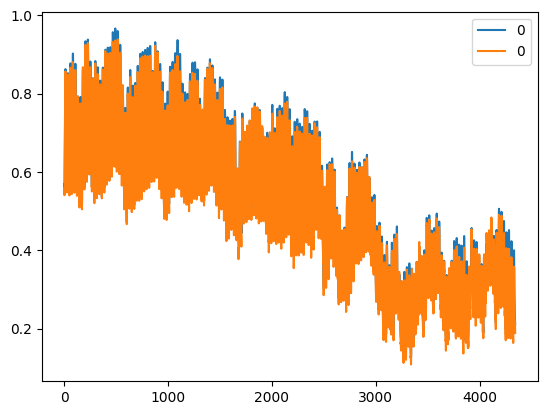

In [46]:
pd.concat((orig.iloc[:, 0], pred.iloc[:, 0]), axis=1).plot()

<AxesSubplot: >

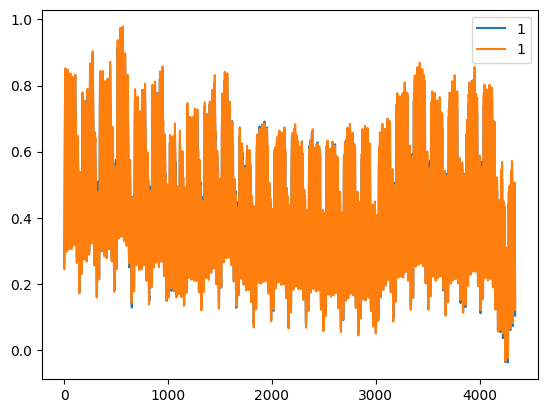

In [47]:
pd.concat((orig.iloc[:, 1], pred.iloc[:, 1]), axis=1).plot()

<AxesSubplot: >

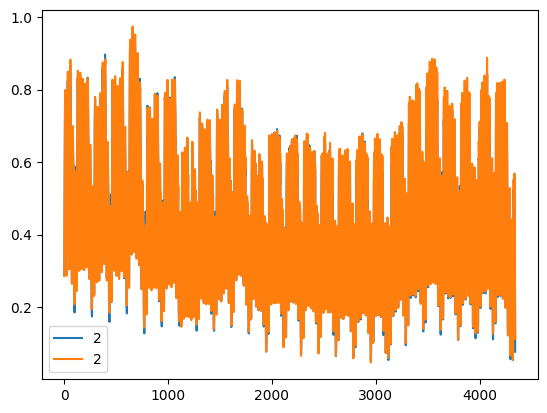

In [48]:
pd.concat((orig.iloc[:, 2], pred.iloc[:, 2]), axis=1).plot()

In [49]:
mape(orig.iloc[:, 0], pred.iloc[:, 0])

1.8571903929114342

In [50]:
mape(orig.iloc[:, 1], pred.iloc[:, 1])

1.8472323194146156

In [51]:
mape(orig.iloc[:, 2], pred.iloc[:, 2])

2.439565025269985

In [52]:
print("Saving the best trained models.")

# Saving the models
torch.save(best_vae_lstm_model_1, f"vae_models/L3_best_zone_1.pth")
torch.save(best_vae_lstm_model_2, f"vae_models/L3_best_zone_2.pth")
torch.save(best_vae_lstm_model_3, f"vae_models/L3_best_zone_3.pth")
torch.save(best_vae_lstm_model_4, f"vae_models/L3_best_zone_4.pth")
torch.save(best_vae_lstm_model_5, f"vae_models/L3_best_zone_5.pth")
torch.save(best_vae_lstm_model_6, f"vae_models/L3_best_zone_6.pth")
torch.save(best_vae_lstm_model_7, f"vae_models/L3_best_zone_7.pth")
torch.save(best_vae_lstm_model_8, f"vae_models/L3_best_zone_8.pth")
torch.save(best_vae_lstm_model_9, f"vae_models/L3_best_zone_9.pth")
torch.save(best_vae_lstm_model_10, f"vae_models/L3_best_zone_10.pth")
torch.save(best_vae_lstm_model_11, f"vae_models/L3_best_zone_11.pth")
torch.save(best_vae_lstm_model_12, f"vae_models/L3_best_zone_12.pth")
torch.save(best_vae_lstm_model_13, f"vae_models/L3_best_zone_13.pth")
torch.save(best_vae_lstm_model_14, f"vae_models/L3_best_zone_14.pth")

print("Saved !")

Saving the best trained models.
Saved !


In [53]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}